<a href="https://colab.research.google.com/github/SJharbade/Advance/blob/main/BasicGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Libraries
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


In [ ]:
from torch.nn import Module

In [ ]:
# Visualization Function
def show(tensor,ch =1, size = (28,28), num = 16):
  # Total tensor here will be 128 X 784
  data = tensor.detach().cpu().view(-1, ch,*size)
  grid = make_grid(data[:num],nrow = 4).permute(1,2,0)
  plt.imshow(grid)
  plt.show()

In [ ]:
# Set up main parmeters and hyper parameters
epochs = 500
cur_step = 0 ## Starting Steps
info_step = 300 ## This is parameter that show after how many steps we wants to show the current loss value
mean_gn_loss = 0 # Mean generator Loss
mean_desc_loss = 0  # mean discrimator loss

z_dim = 64 # dimensionality of noise vector generator by input generator
lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()

bs = 128
device = 'cuda'

dataloader = DataLoader(MNIST('.',download = True, transform = transforms.ToTensor()),shuffle = True, batch_size = bs)

In [ ]:
# declare our Models

#Generator
def genBlock(inp,out):
  return nn.Sequential(
      nn.Linear(inp,out),
      nn.BatchNorm1d(out),
      nn.ReLU(inplace = True)
  )

class Generator(nn.Module):
  def __init__(self, z_dim =64, i_dim = 784, h_dim = 128): # h_dim =hidden Layer, i_dim = Size of output(28*28 size of MNIST DB), z_dim = size of input noise latent vector
    super().__init__() #### Initilize Paranet class
    self.gen = nn.Sequential(   # We will gradually increase the size of until we reach as the sam esize of MNIST dataset
        genBlock(z_dim, h_dim),
        genBlock(h_dim, h_dim*2),
        genBlock(h_dim*2, h_dim*4),
        genBlock(h_dim*4, h_dim*8),
        nn.Linear(h_dim*8,i_dim),
        nn.Sigmoid(),
    )
  def forward(self,noise):
    return self.gen(noise)

def gen_noise(number,z_dim):
    return torch.randn(number, z_dim).to(device)

 # Discriminator
def discBlock(inp,out):
  return nn.Sequential(
      nn.Linear(inp,out),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self,i_dim = 784, h_dim = 256):
    super().__init__()
    self.disc = nn.Sequential(
        discBlock(i_dim,h_dim*4),
        discBlock(h_dim*4,h_dim*2),
        discBlock(h_dim*2,h_dim),
        nn.Linear(h_dim,1)
    )

  def forward(self,image):
    return self.disc(image)


In [ ]:
gen = Generator(z_dim).to(device)
gen_optim = torch.optim.Adam(gen.parameters(), lr=lr)

disc = Discriminator().to(device)
disc_optim = torch.optim.Adam(disc.parameters(),lr=lr)


In [ ]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([8, 5, 5, 5, 5, 1, 1, 8, 5, 8])


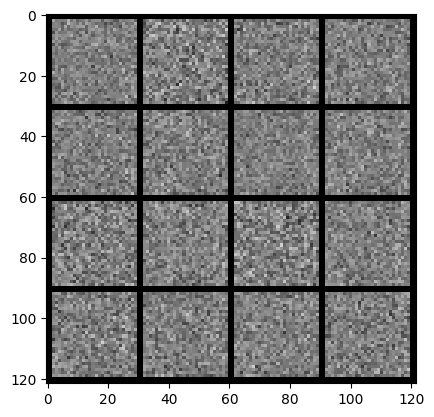

In [ ]:
x,y = next(iter(dataloader))
print(x.shape,y.shape)
print(y[:10])

noise =gen_noise(bs,z_dim)
fake = gen(noise)
show(fake)

In [ ]:
# CAlculating the loss

# generator loss
def calc_gen_loss(loss_func, gen,disc,number,z_dim):
  noise = gen_noise(number,z_dim)
  fake = gen(noise)
  pred = disc(fake)
  targets = torch.ones_like(pred)
  gen_loss = loss_func(pred,targets)

  return gen_loss
# Discriminator loss

def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
  noise = gen_noise(number,z_dim)
  fake = gen(noise)
  disc_fake = disc(fake.detach())
  disc_fake_targets = torch.zeros_like(disc_fake)
  disc_fake_loss = loss_func(disc_fake, disc_fake_targets)

  disc_real = disc(real)
  disc_real_targets = torch.ones_like(disc_real)
  disc_real_loss = loss_func(disc_real,disc_real_targets)

  disc_loss = (disc_fake_loss + disc_real_loss)/2

  return disc_loss



  0%|          | 0/469 [00:00<?, ?it/s]

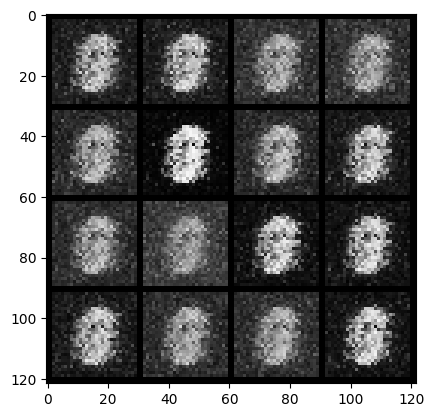

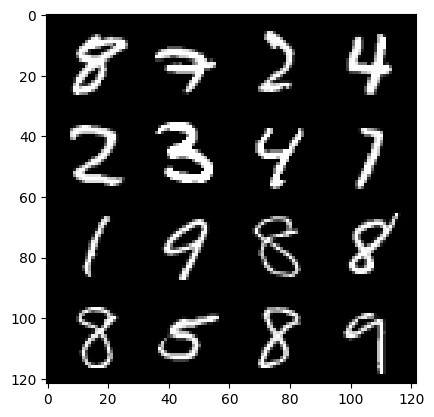

0 : step 300 / Gen Loss: 0.011623547871907553 / disc loss: 0.0004283995429674784


  0%|          | 0/469 [00:00<?, ?it/s]

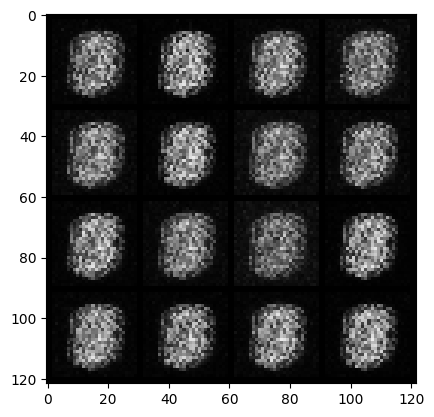

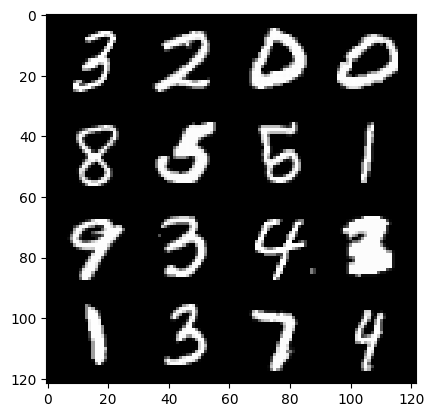

1 : step 600 / Gen Loss: 0.011261049906412761 / disc loss: 0.0002774449437856674


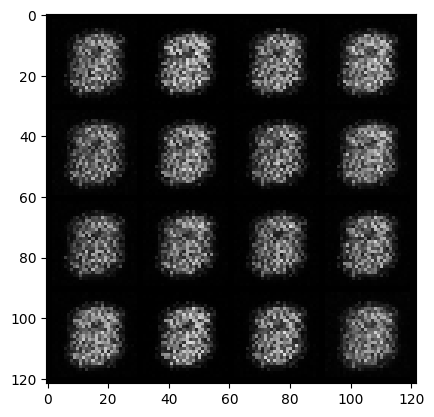

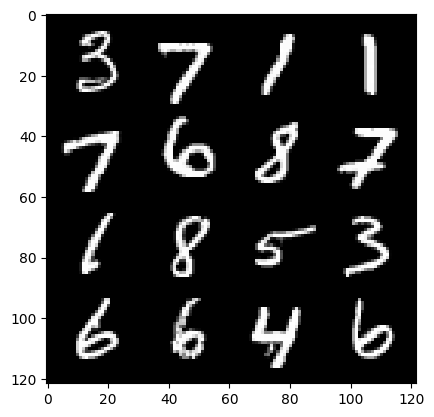

1 : step 900 / Gen Loss: 0.011303645769755045 / disc loss: 0.00017338410019874574


  0%|          | 0/469 [00:00<?, ?it/s]

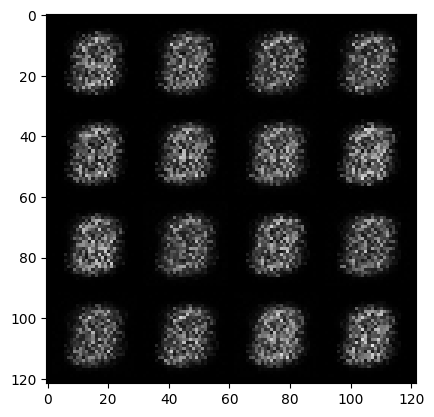

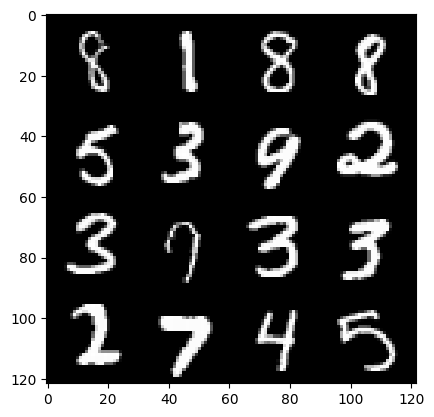

2 : step 1200 / Gen Loss: 0.011816368103027344 / disc loss: 0.00012023436526457469


  0%|          | 0/469 [00:00<?, ?it/s]

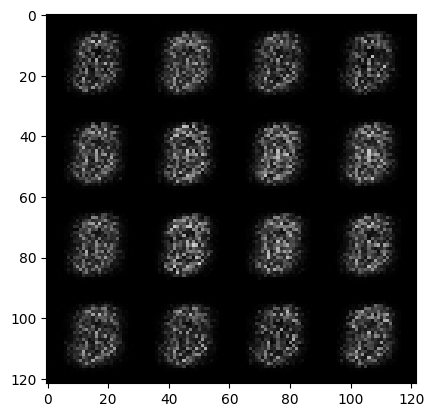

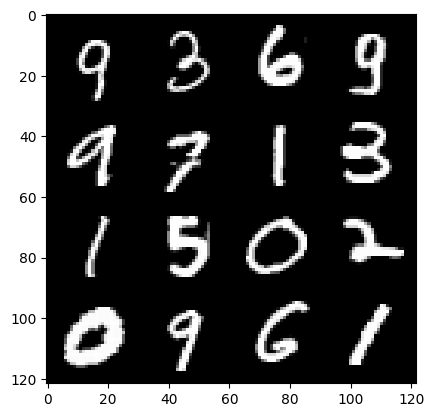

3 : step 1500 / Gen Loss: 0.011242626508076985 / disc loss: 0.00018453737099965415


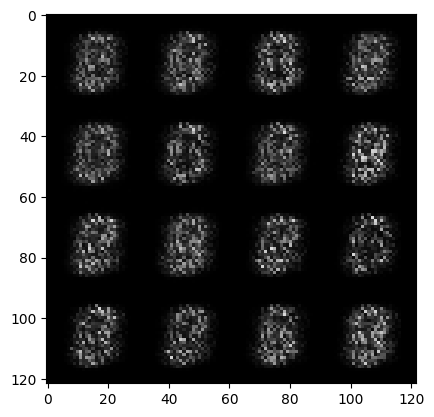

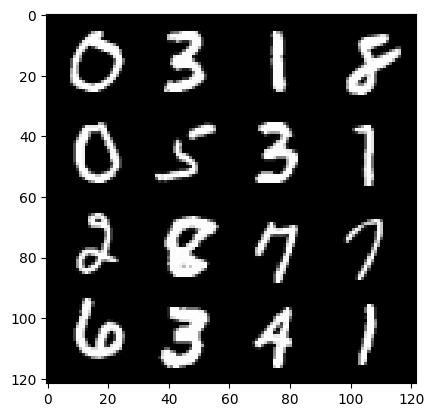

3 : step 1800 / Gen Loss: 0.011355326970418295 / disc loss: 0.00011157943556706111


  0%|          | 0/469 [00:00<?, ?it/s]

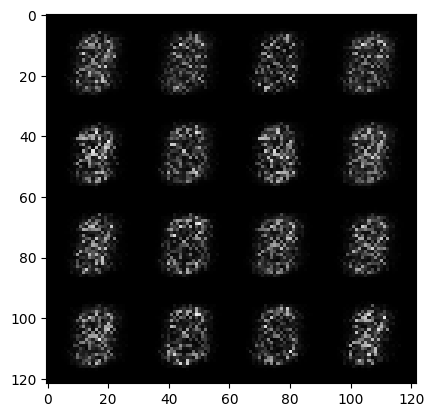

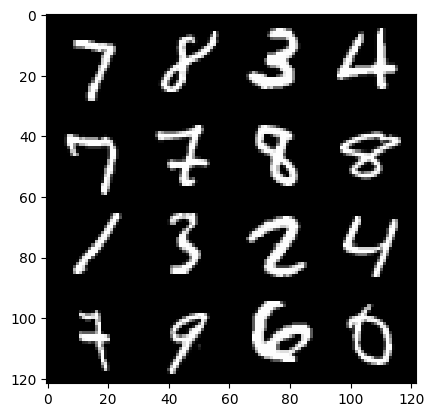

4 : step 2100 / Gen Loss: 0.012998871008555095 / disc loss: 7.626857608556747e-05


  0%|          | 0/469 [00:00<?, ?it/s]

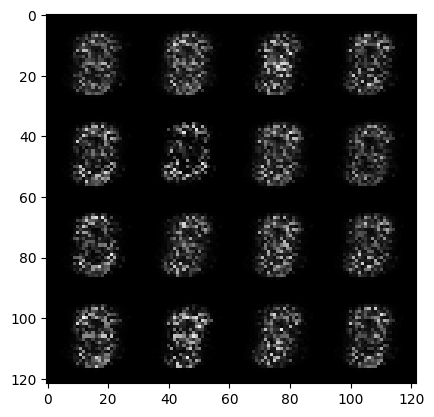

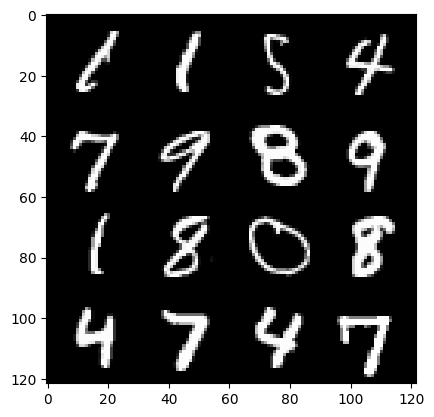

5 : step 2400 / Gen Loss: 0.013744614919026692 / disc loss: 9.675279259681702e-05


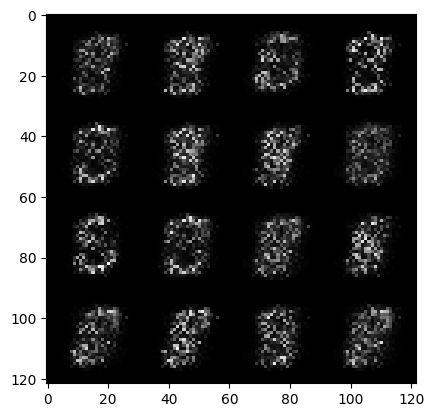

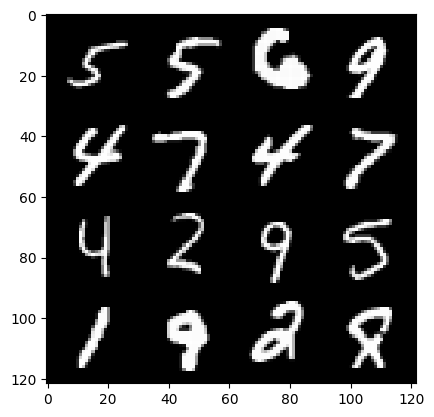

5 : step 2700 / Gen Loss: 0.01518812338511149 / disc loss: 0.00010782768328984579


  0%|          | 0/469 [00:00<?, ?it/s]

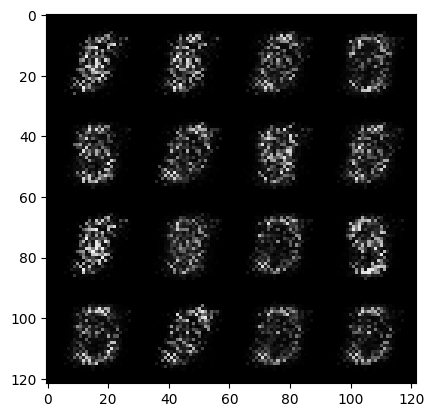

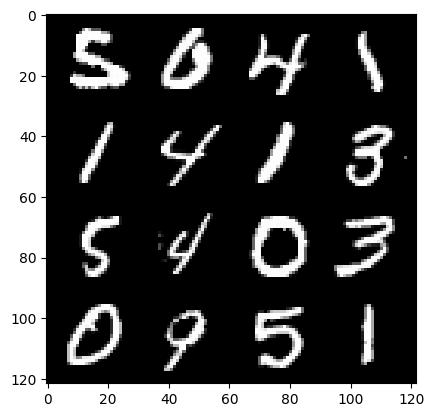

6 : step 3000 / Gen Loss: 0.018166985511779785 / disc loss: 4.134569006661574e-05


  0%|          | 0/469 [00:00<?, ?it/s]

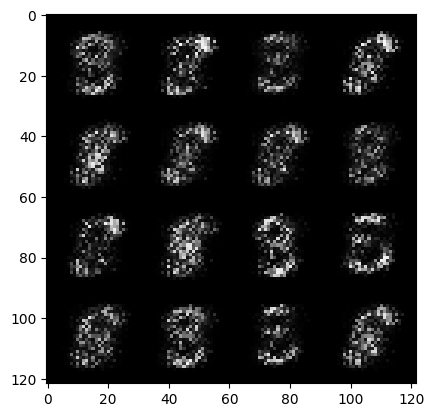

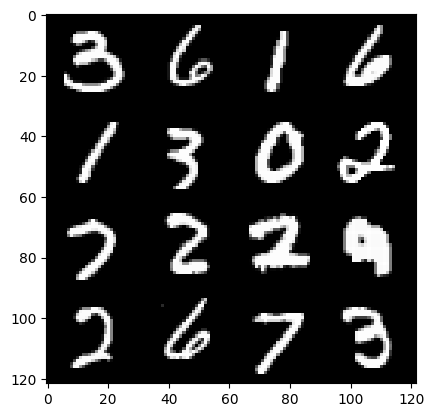

7 : step 3300 / Gen Loss: 0.015734469095865886 / disc loss: 5.15132707854112e-05


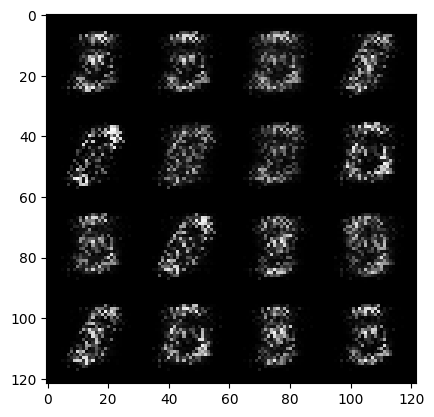

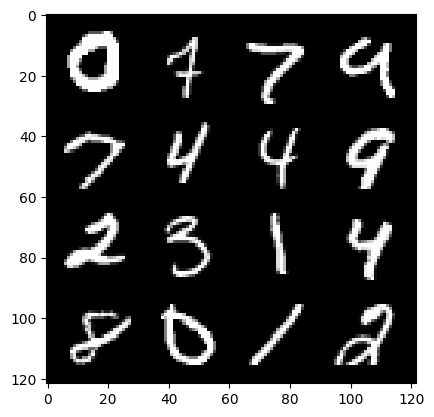

7 : step 3600 / Gen Loss: 0.01805452346801758 / disc loss: 6.334775437911351e-05


  0%|          | 0/469 [00:00<?, ?it/s]

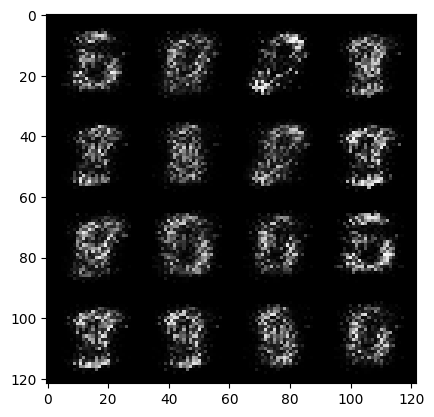

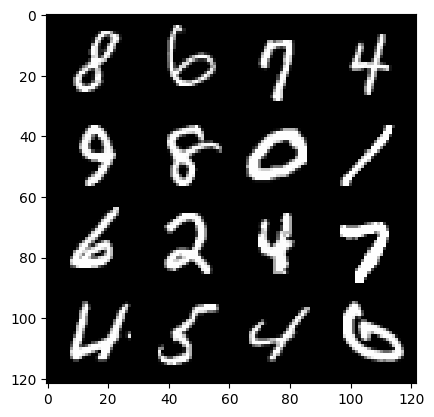

8 : step 3900 / Gen Loss: 0.019053961435953778 / disc loss: 6.537832319736481e-05


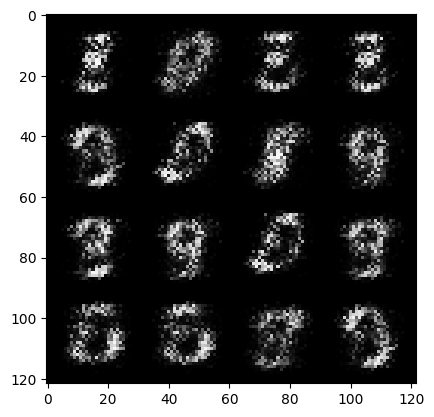

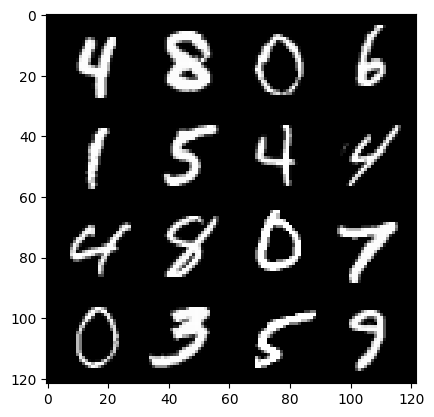

8 : step 4200 / Gen Loss: 0.018955979347229004 / disc loss: 9.315407524506251e-05


  0%|          | 0/469 [00:00<?, ?it/s]

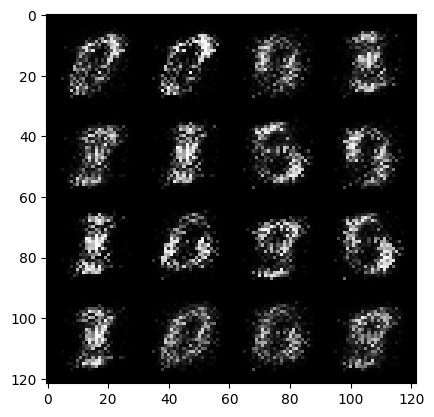

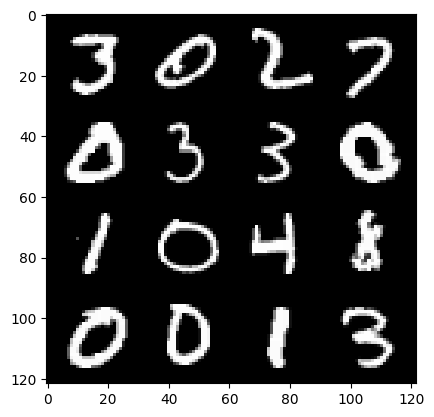

9 : step 4500 / Gen Loss: 0.020221516291300454 / disc loss: 5.0896772493918736e-05


  0%|          | 0/469 [00:00<?, ?it/s]

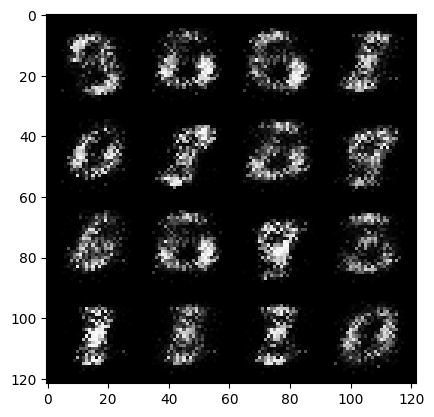

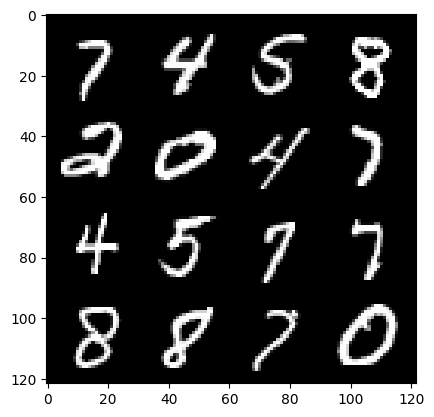

10 : step 4800 / Gen Loss: 0.020360873540242512 / disc loss: 6.426506986220678e-05


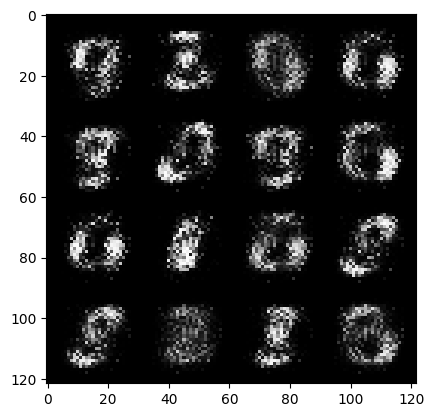

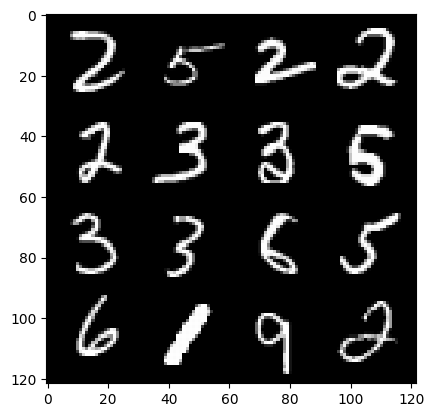

10 : step 5100 / Gen Loss: 0.020704708099365234 / disc loss: 7.285357763369878e-05


  0%|          | 0/469 [00:00<?, ?it/s]

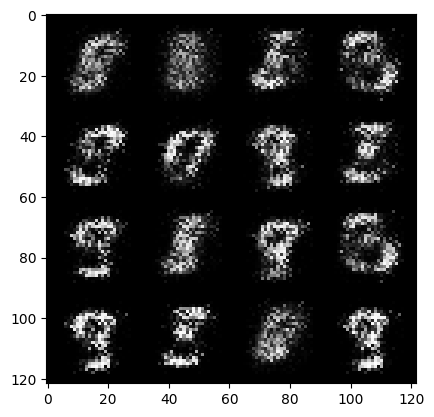

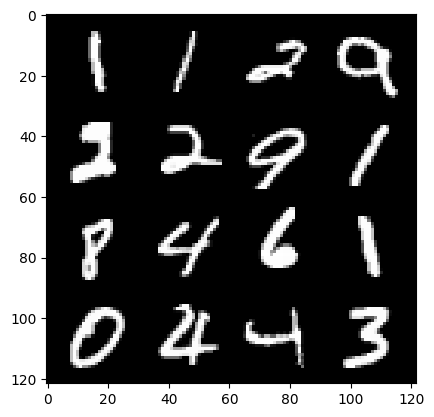

11 : step 5400 / Gen Loss: 0.0213105583190918 / disc loss: 4.949103109538555e-05


  0%|          | 0/469 [00:00<?, ?it/s]

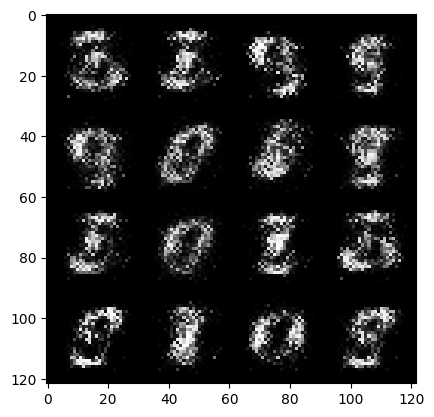

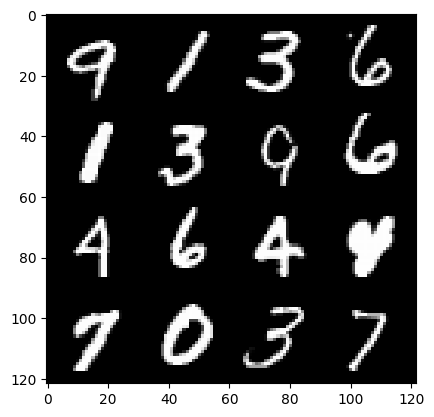

12 : step 5700 / Gen Loss: 0.022377750078837078 / disc loss: 7.145839432875316e-05


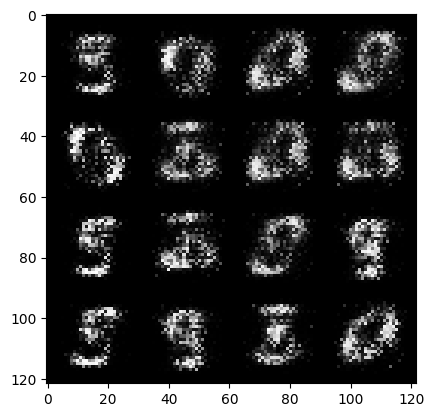

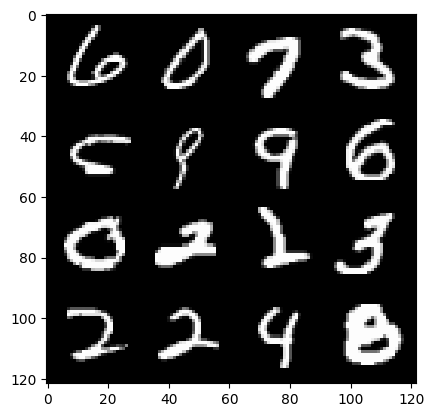

12 : step 6000 / Gen Loss: 0.023912150065104165 / disc loss: 5.568243563175201e-05


  0%|          | 0/469 [00:00<?, ?it/s]

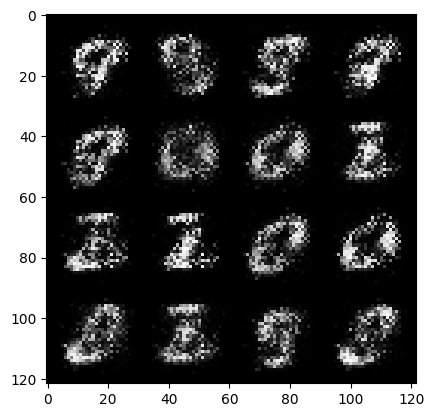

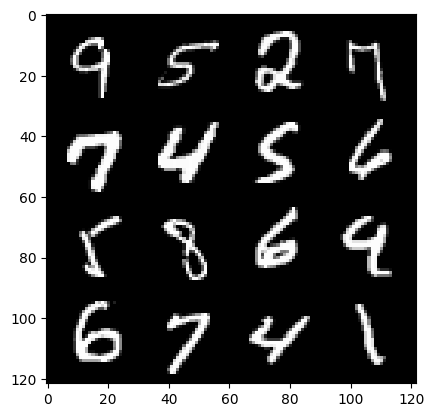

13 : step 6300 / Gen Loss: 0.021972440083821616 / disc loss: 3.179299955566724e-05


  0%|          | 0/469 [00:00<?, ?it/s]

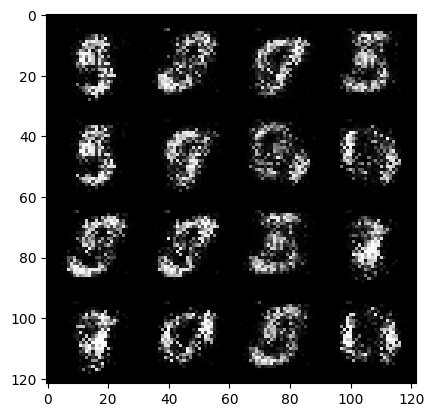

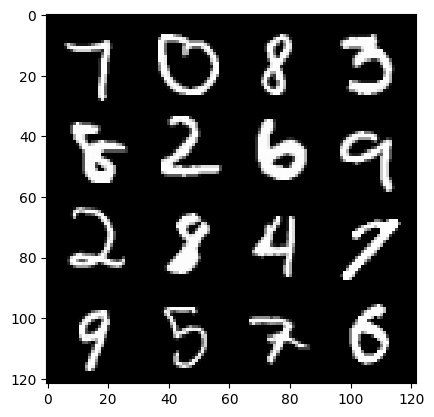

14 : step 6600 / Gen Loss: 0.02315129280090332 / disc loss: 0.00011294881502787272


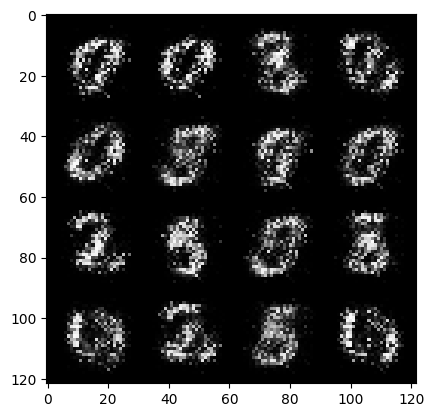

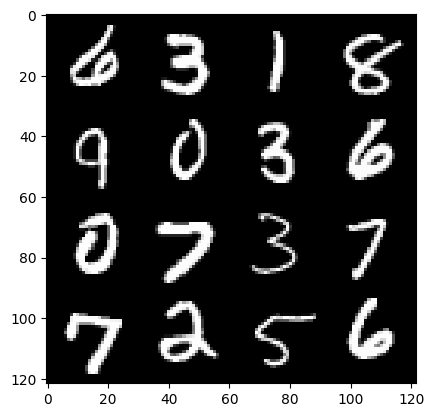

14 : step 6900 / Gen Loss: 0.021734358469645183 / disc loss: 2.0510594670971234e-05


  0%|          | 0/469 [00:00<?, ?it/s]

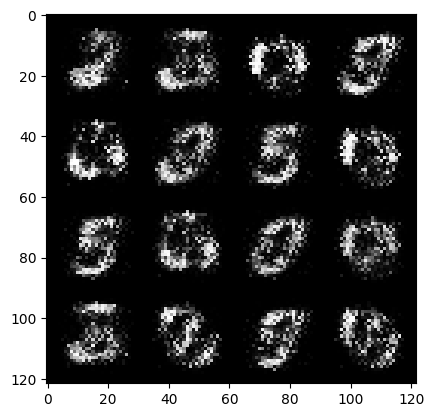

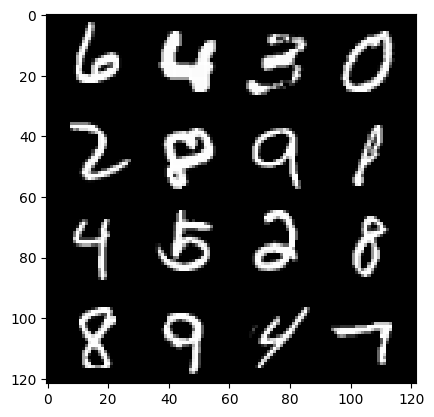

15 : step 7200 / Gen Loss: 0.024498955408732096 / disc loss: 4.365080967545509e-05


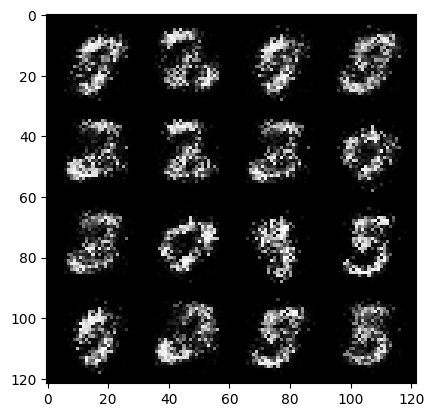

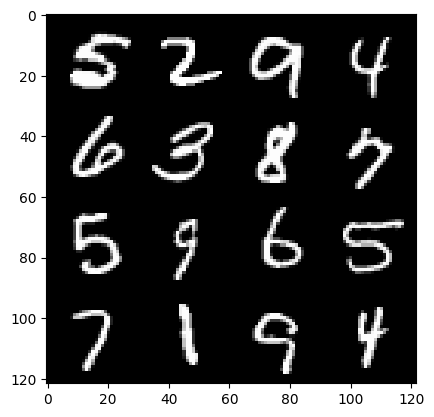

15 : step 7500 / Gen Loss: 0.023959681193033853 / disc loss: 3.030824474990368e-05


  0%|          | 0/469 [00:00<?, ?it/s]

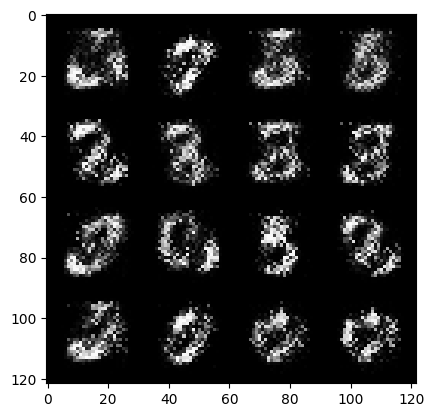

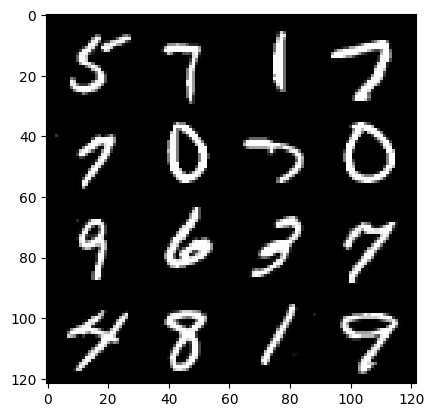

16 : step 7800 / Gen Loss: 0.02552953243255615 / disc loss: 2.1138085673252743e-05


  0%|          | 0/469 [00:00<?, ?it/s]

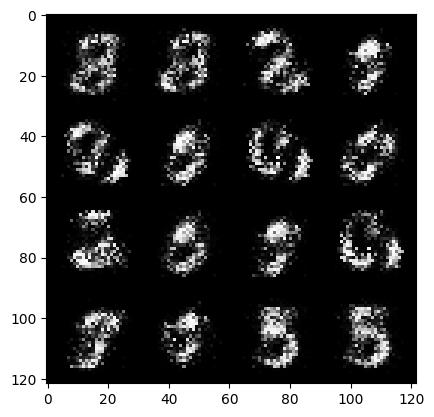

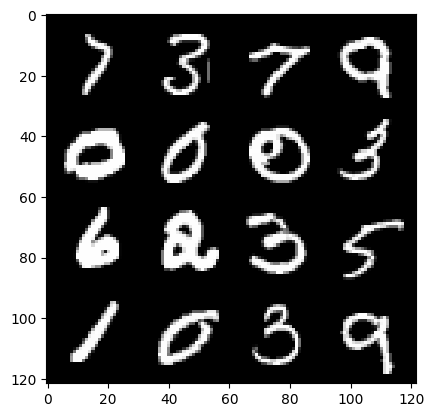

17 : step 8100 / Gen Loss: 0.024108734130859375 / disc loss: 2.109458359579245e-05


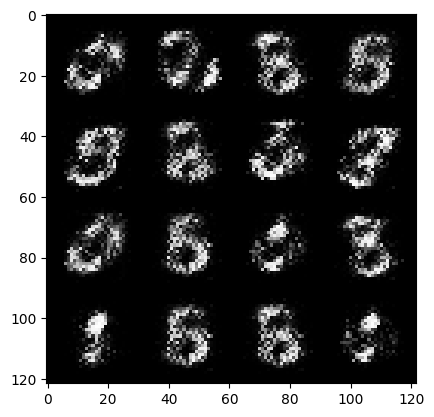

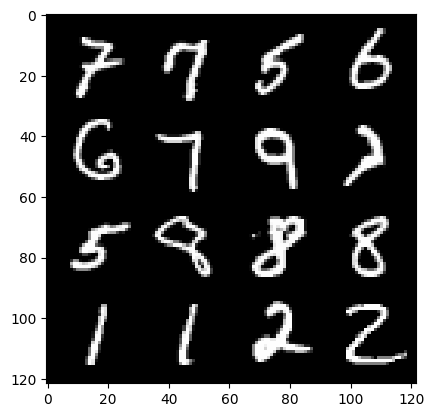

17 : step 8400 / Gen Loss: 0.022273894945780436 / disc loss: 4.200805599490801e-05


  0%|          | 0/469 [00:00<?, ?it/s]

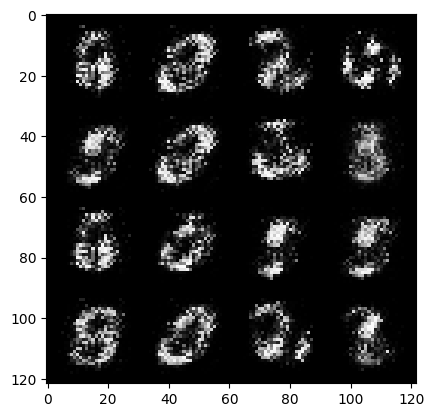

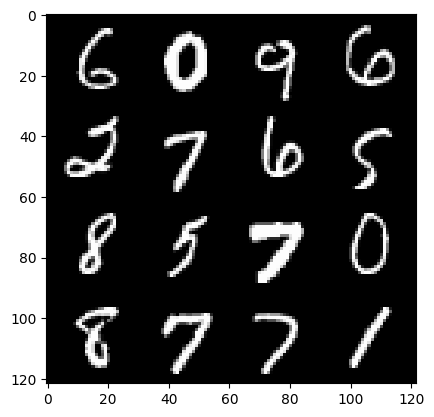

18 : step 8700 / Gen Loss: 0.022258475621541342 / disc loss: 2.499876543879509e-05


  0%|          | 0/469 [00:00<?, ?it/s]

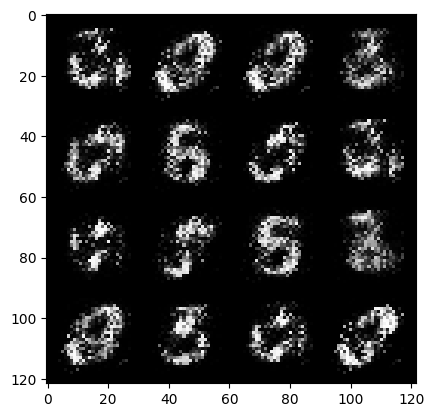

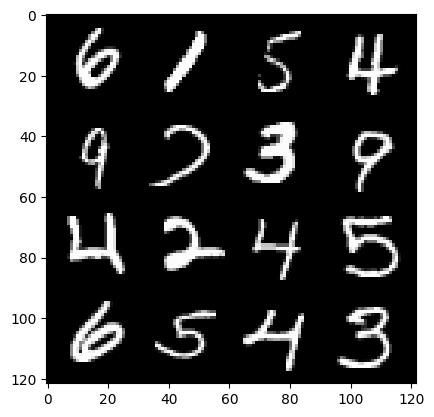

19 : step 9000 / Gen Loss: 0.022523396809895832 / disc loss: 1.7732130363583564e-05


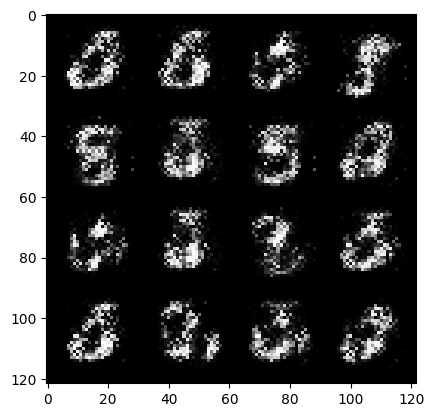

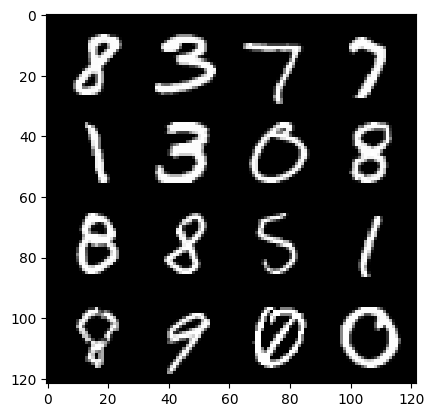

19 : step 9300 / Gen Loss: 0.022346442540486653 / disc loss: 2.4388819001615046e-05


  0%|          | 0/469 [00:00<?, ?it/s]

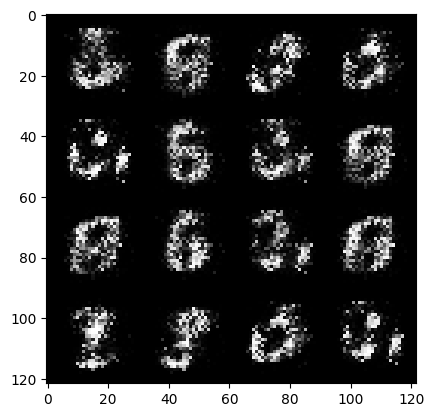

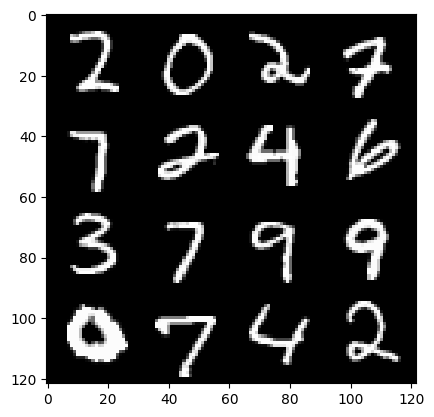

20 : step 9600 / Gen Loss: 0.024496213595072428 / disc loss: 1.9202216838796932e-05


  0%|          | 0/469 [00:00<?, ?it/s]

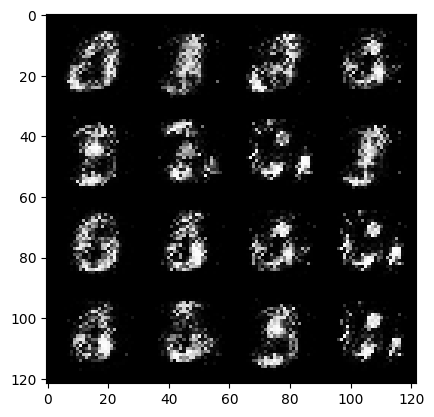

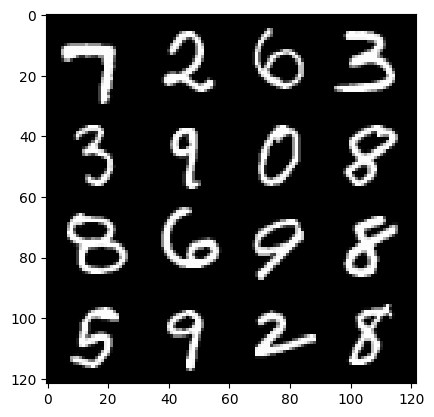

21 : step 9900 / Gen Loss: 0.022258005142211913 / disc loss: 5.0897542387247085e-05


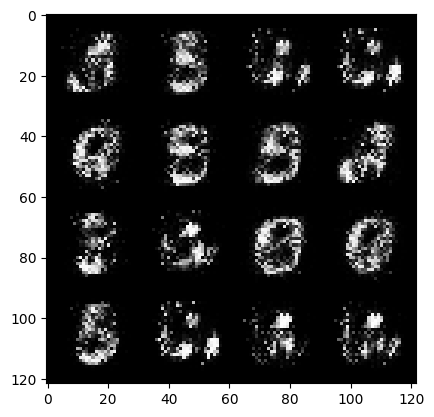

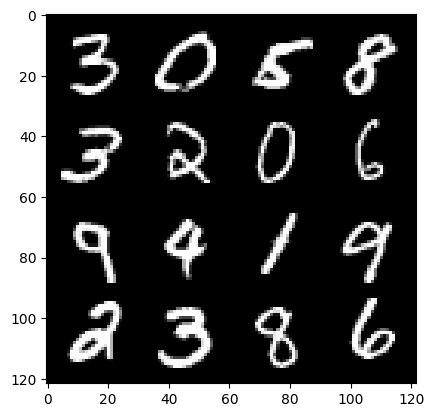

21 : step 10200 / Gen Loss: 0.023939414024353026 / disc loss: 2.775934524834156e-05


  0%|          | 0/469 [00:00<?, ?it/s]

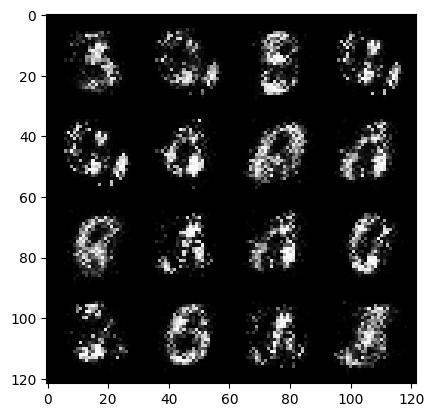

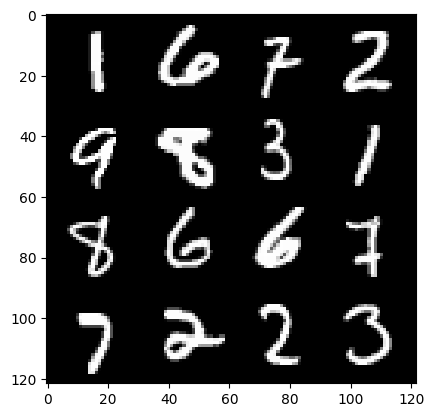

22 : step 10500 / Gen Loss: 0.021255804697672527 / disc loss: 4.843123567601045e-05


  0%|          | 0/469 [00:00<?, ?it/s]

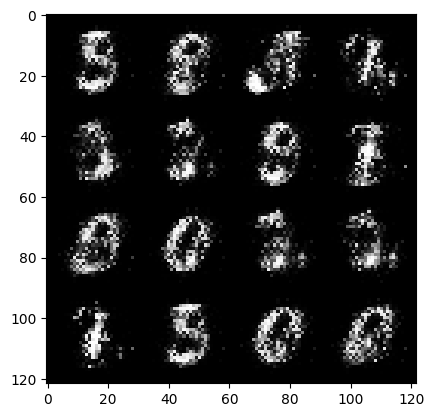

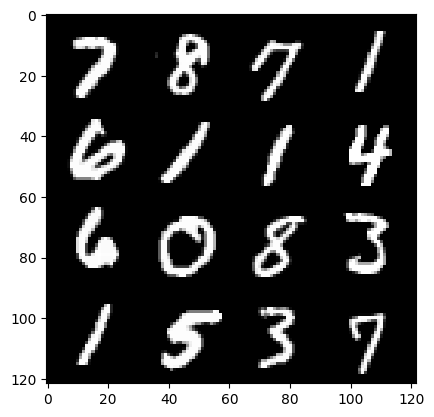

23 : step 10800 / Gen Loss: 0.021185890833536784 / disc loss: 3.0060842012365658e-05


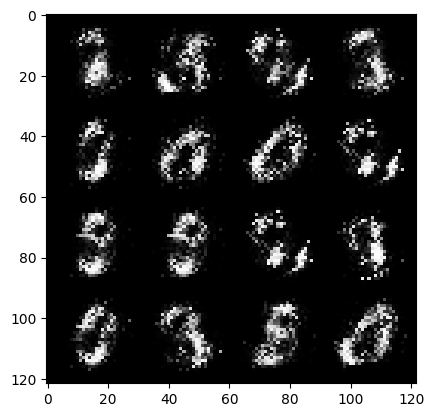

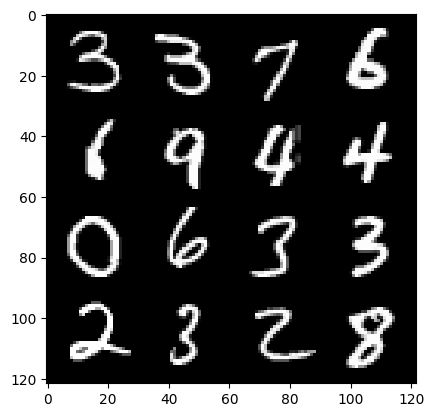

23 : step 11100 / Gen Loss: 0.021140998204549153 / disc loss: 4.1562095284461974e-05


  0%|          | 0/469 [00:00<?, ?it/s]

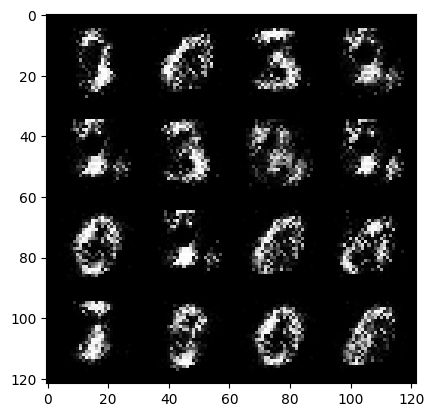

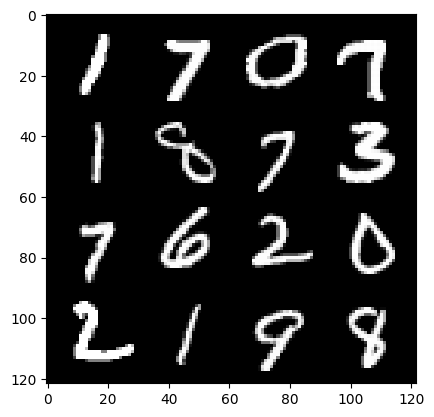

24 : step 11400 / Gen Loss: 0.025954488118489584 / disc loss: 3.283347934484482e-05


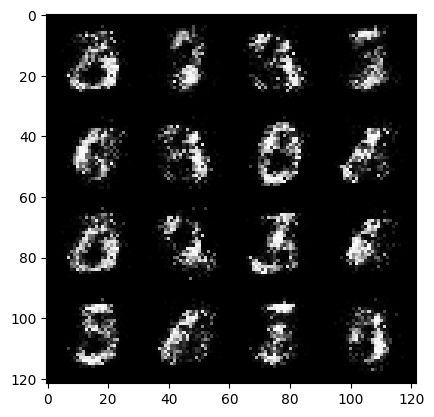

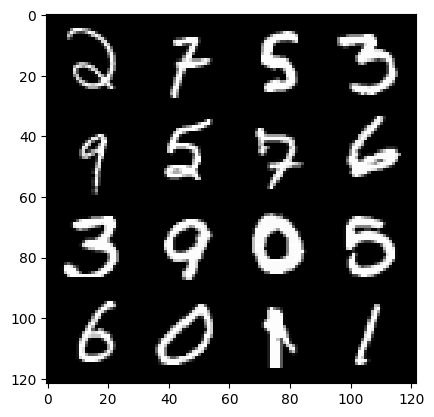

24 : step 11700 / Gen Loss: 0.025800585746765137 / disc loss: 1.828921027481556e-05


  0%|          | 0/469 [00:00<?, ?it/s]

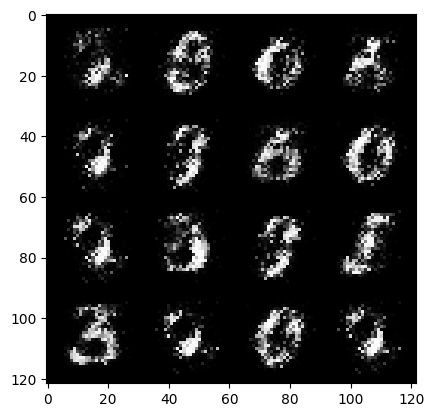

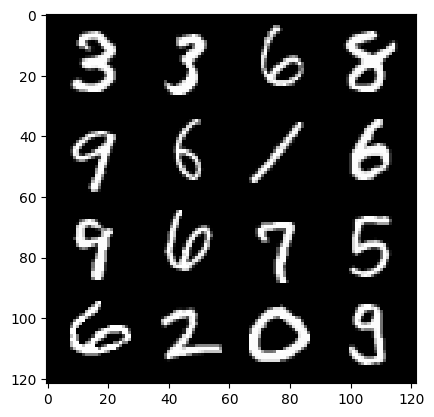

25 : step 12000 / Gen Loss: 0.022487376530965168 / disc loss: 2.8389263898134233e-05


  0%|          | 0/469 [00:00<?, ?it/s]

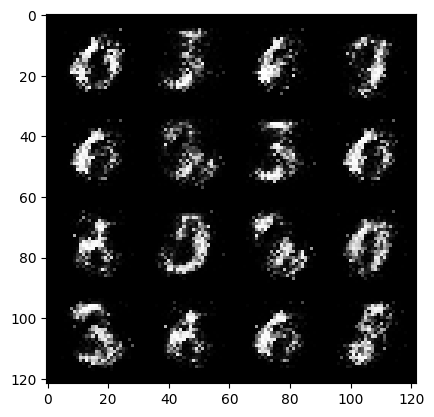

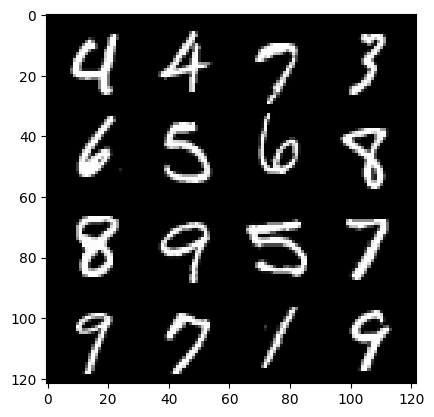

26 : step 12300 / Gen Loss: 0.022322731018066408 / disc loss: 1.6491712691883247e-05


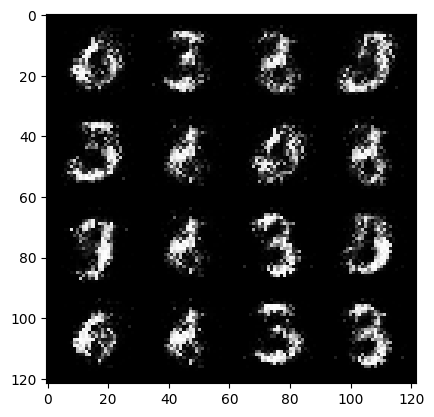

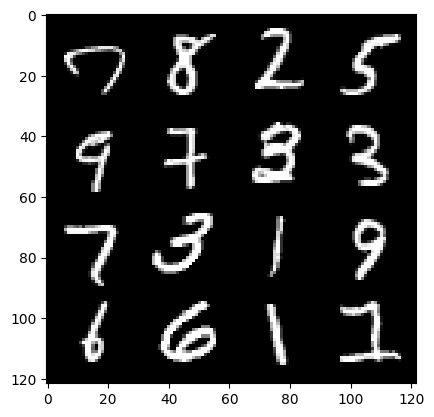

26 : step 12600 / Gen Loss: 0.02401856263478597 / disc loss: 3.0768457800149915e-05


  0%|          | 0/469 [00:00<?, ?it/s]

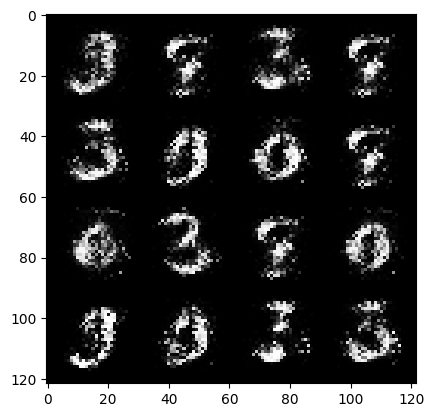

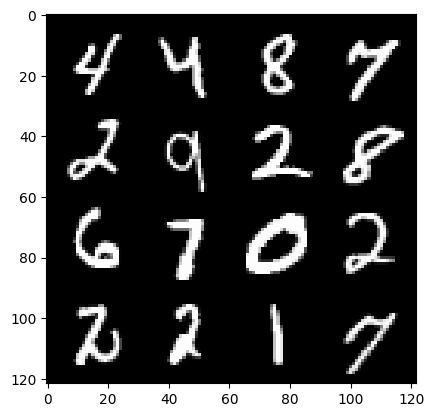

27 : step 12900 / Gen Loss: 0.027846272786458334 / disc loss: 3.862950329979261e-05


  0%|          | 0/469 [00:00<?, ?it/s]

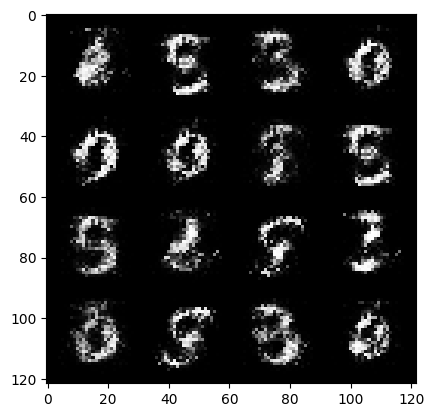

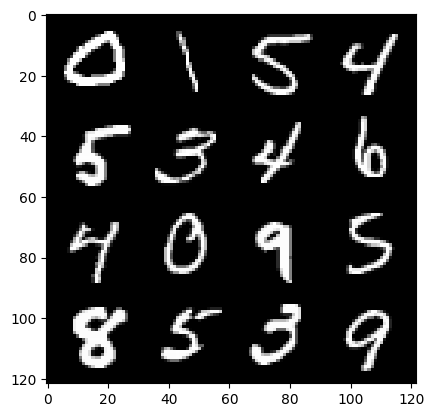

28 : step 13200 / Gen Loss: 0.027183732986450194 / disc loss: 3.933822736144066e-05


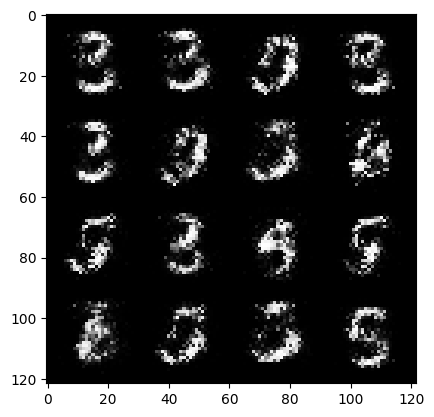

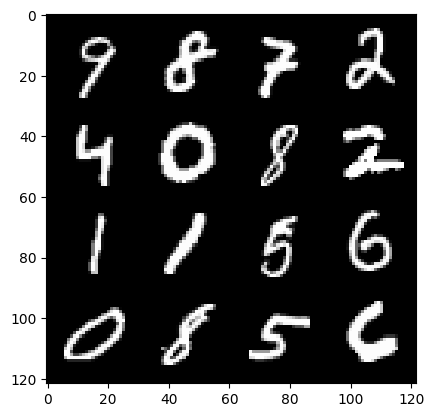

28 : step 13500 / Gen Loss: 0.02562721570332845 / disc loss: 2.5274166837334633e-05


  0%|          | 0/469 [00:00<?, ?it/s]

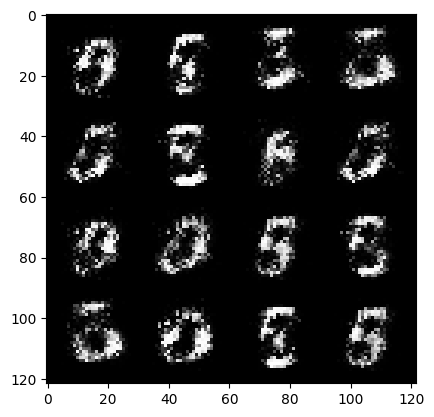

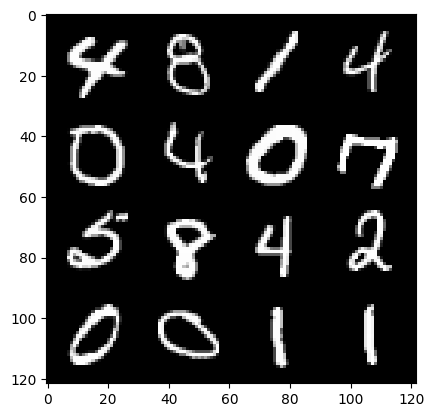

29 : step 13800 / Gen Loss: 0.02374916394551595 / disc loss: 6.743708004554113e-05


  0%|          | 0/469 [00:00<?, ?it/s]

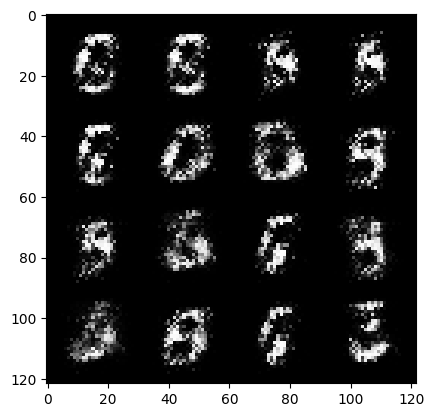

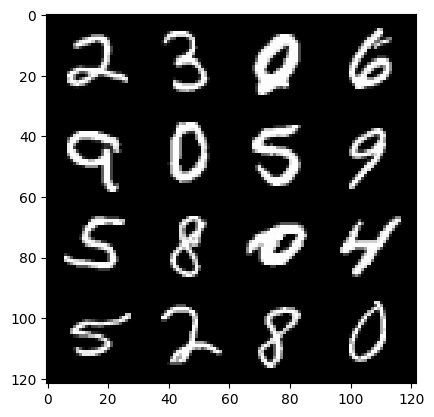

30 : step 14100 / Gen Loss: 0.023136491775512694 / disc loss: 8.937134097019832e-05


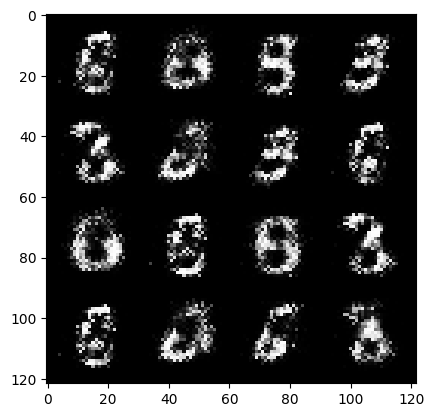

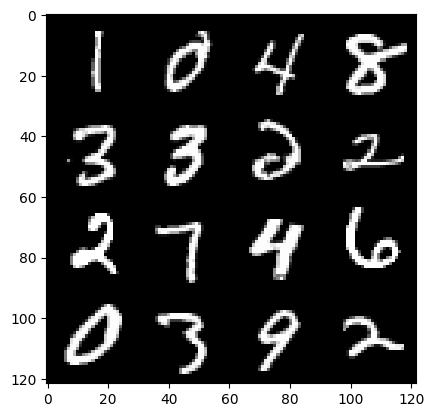

30 : step 14400 / Gen Loss: 0.024863367080688478 / disc loss: 1.9023846834897996e-05


  0%|          | 0/469 [00:00<?, ?it/s]

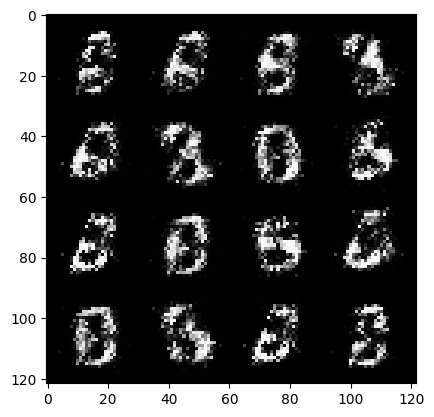

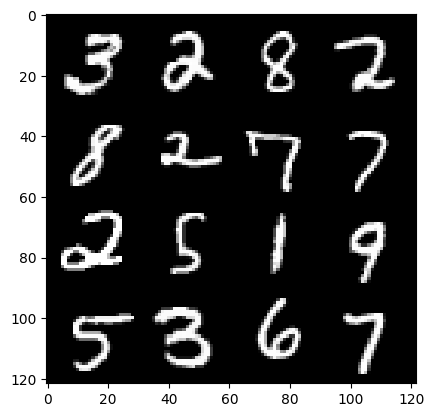

31 : step 14700 / Gen Loss: 0.022978776295979816 / disc loss: 8.046414703130722e-05


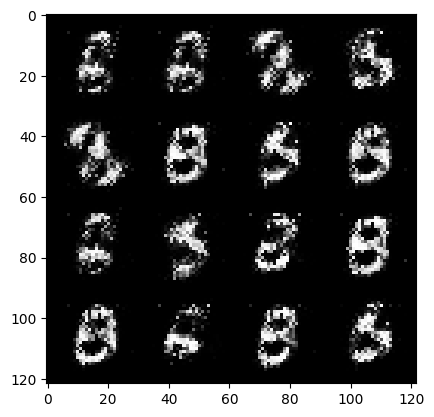

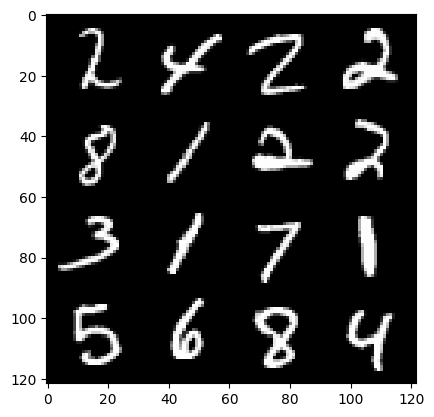

31 : step 15000 / Gen Loss: 0.022114362716674805 / disc loss: 3.796489288409551e-05


  0%|          | 0/469 [00:00<?, ?it/s]

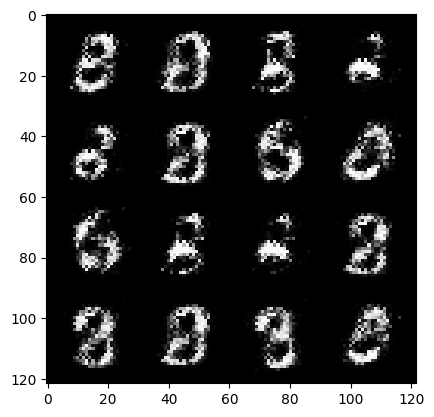

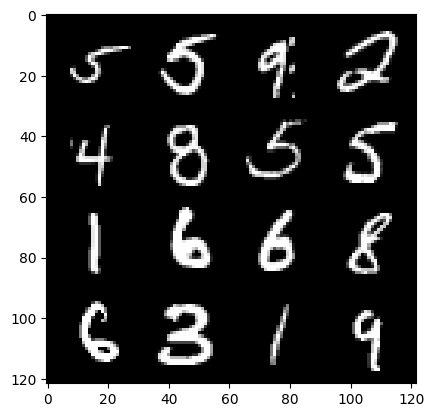

32 : step 15300 / Gen Loss: 0.02404917081197103 / disc loss: 4.165651276707649e-05


  0%|          | 0/469 [00:00<?, ?it/s]

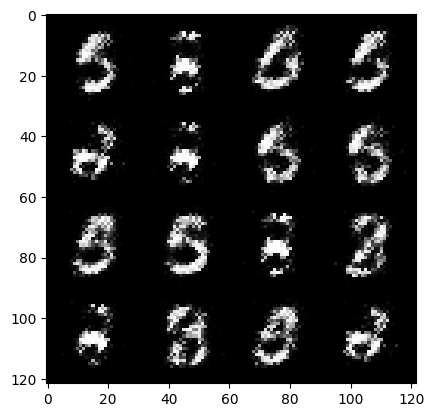

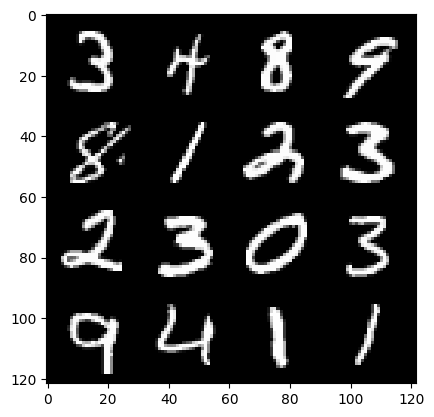

33 : step 15600 / Gen Loss: 0.02000027020772298 / disc loss: 8.823711425065995e-05


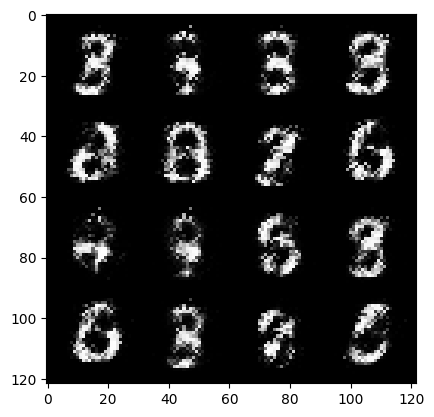

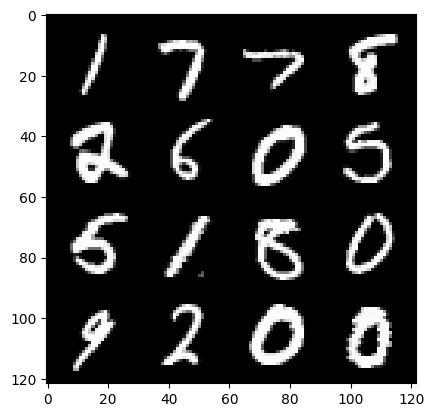

33 : step 15900 / Gen Loss: 0.020420767466227212 / disc loss: 6.316025430957477e-05


  0%|          | 0/469 [00:00<?, ?it/s]

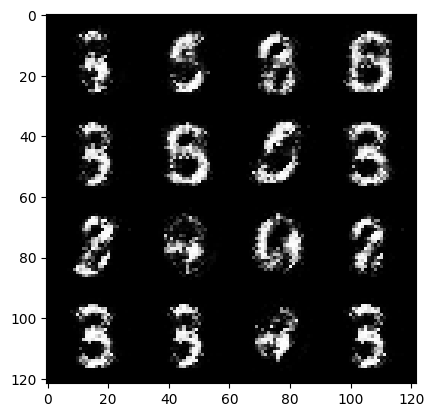

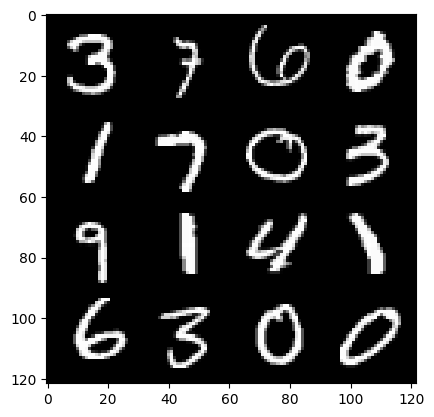

34 : step 16200 / Gen Loss: 0.01999585469563802 / disc loss: 0.00013590044031540553


  0%|          | 0/469 [00:00<?, ?it/s]

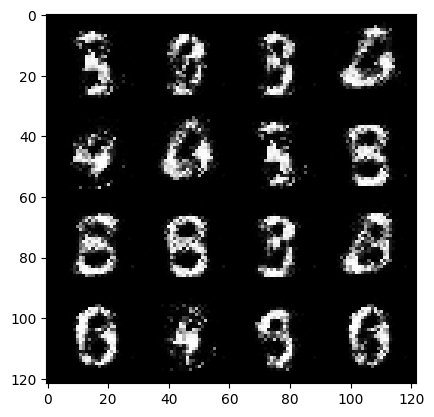

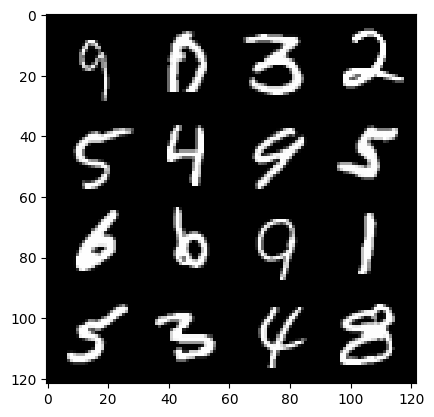

35 : step 16500 / Gen Loss: 0.02126231511433919 / disc loss: 5.2054946621259054e-05


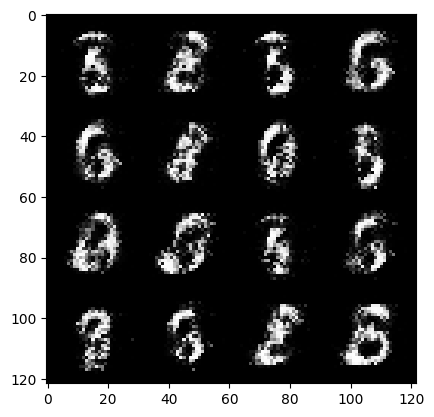

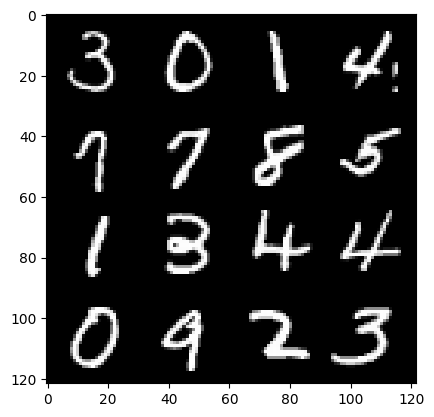

35 : step 16800 / Gen Loss: 0.020756136576334634 / disc loss: 6.970667590697606e-05


  0%|          | 0/469 [00:00<?, ?it/s]

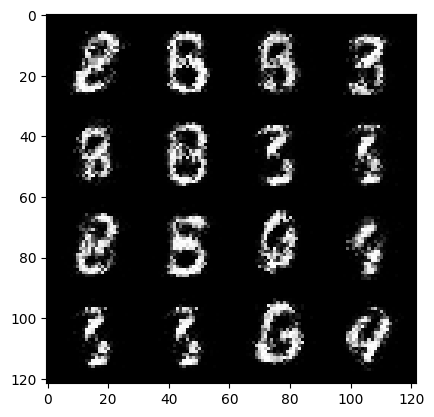

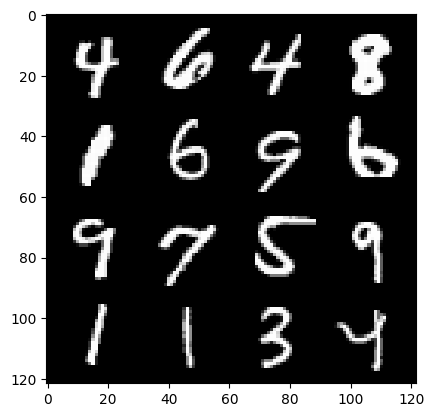

36 : step 17100 / Gen Loss: 0.022501166661580405 / disc loss: 5.151374265551567e-05


  0%|          | 0/469 [00:00<?, ?it/s]

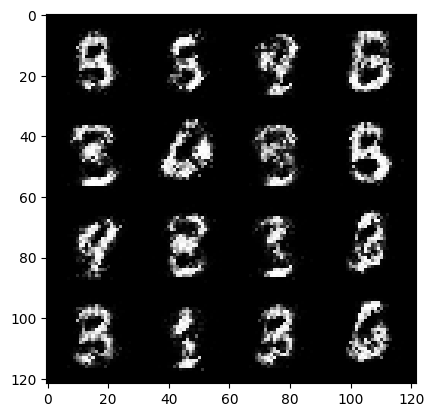

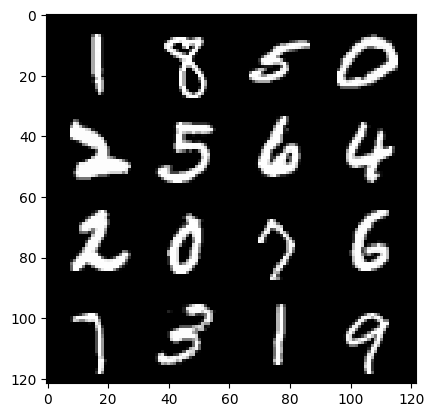

37 : step 17400 / Gen Loss: 0.024726161956787108 / disc loss: 3.501378620664279e-05


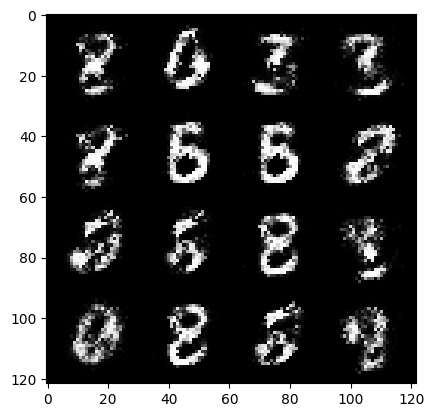

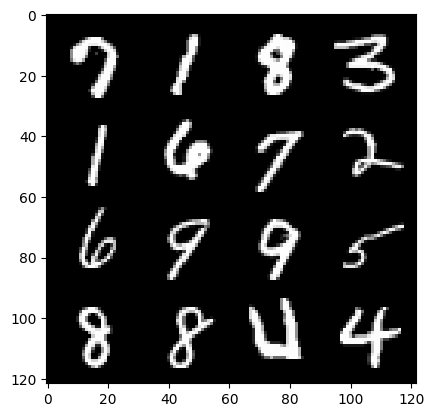

37 : step 17700 / Gen Loss: 0.02059424082438151 / disc loss: 8.103761201103528e-05


  0%|          | 0/469 [00:00<?, ?it/s]

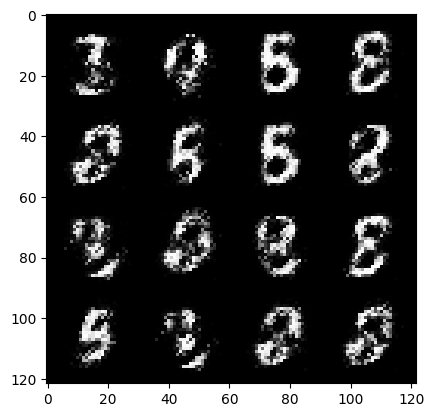

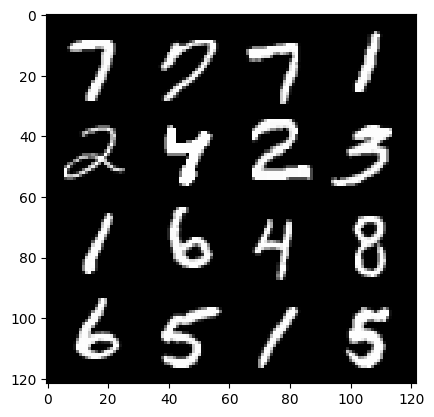

38 : step 18000 / Gen Loss: 0.019542566935221353 / disc loss: 9.392950683832168e-05


  0%|          | 0/469 [00:00<?, ?it/s]

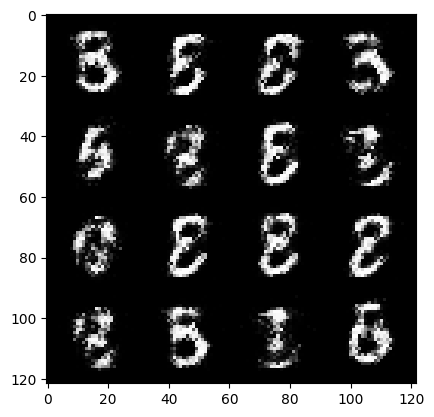

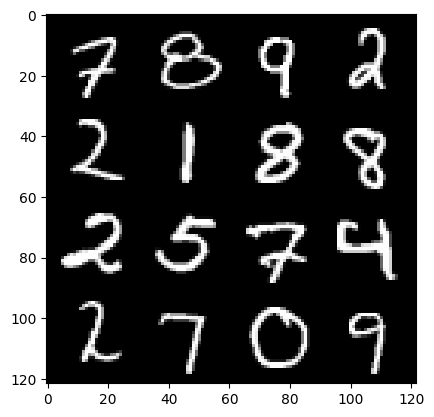

39 : step 18300 / Gen Loss: 0.01734196662902832 / disc loss: 0.00019024675091107687


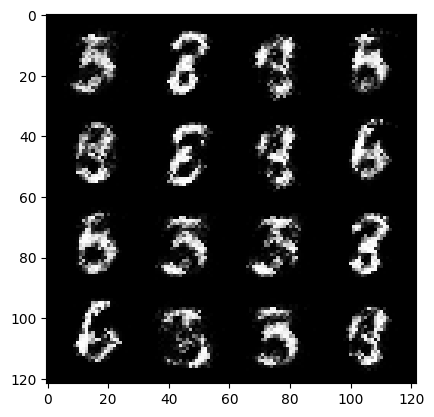

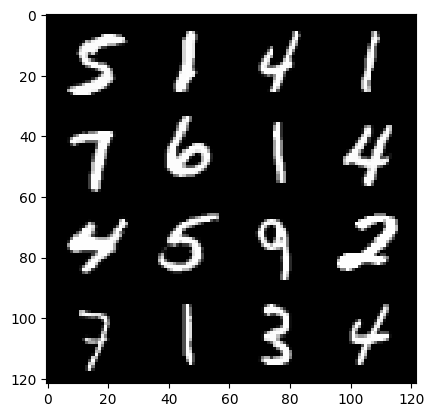

39 : step 18600 / Gen Loss: 0.02082470734914144 / disc loss: 2.900520960489909e-05


  0%|          | 0/469 [00:00<?, ?it/s]

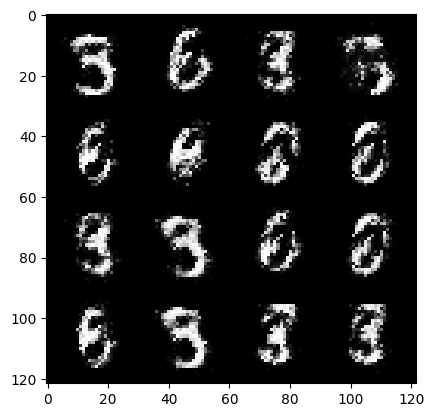

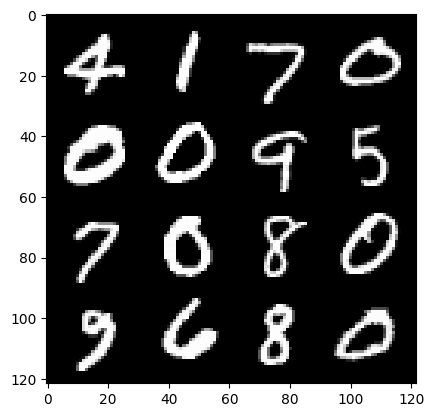

40 : step 18900 / Gen Loss: 0.019991604487101237 / disc loss: 0.000171801894903183


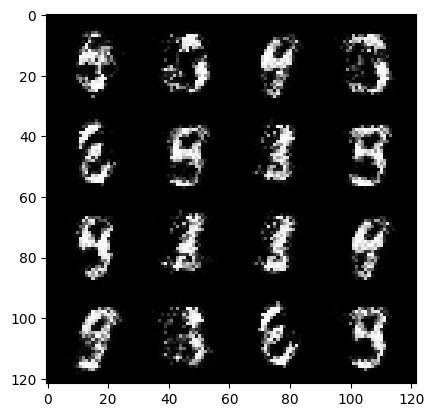

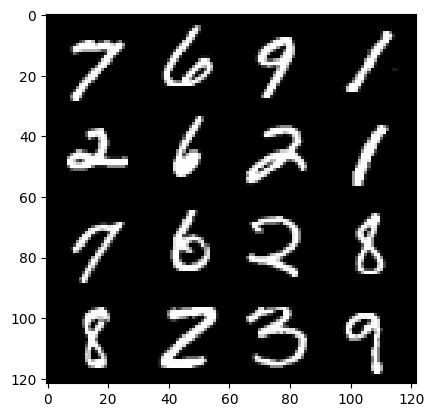

40 : step 19200 / Gen Loss: 0.018729154268900552 / disc loss: 0.00014019548892974854


  0%|          | 0/469 [00:00<?, ?it/s]

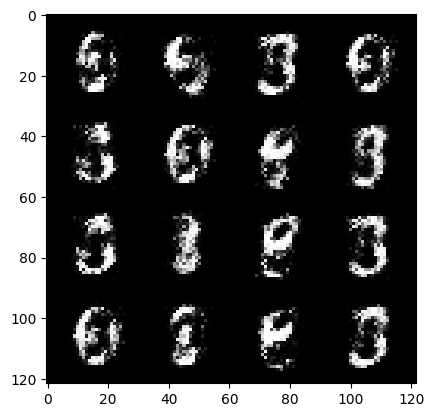

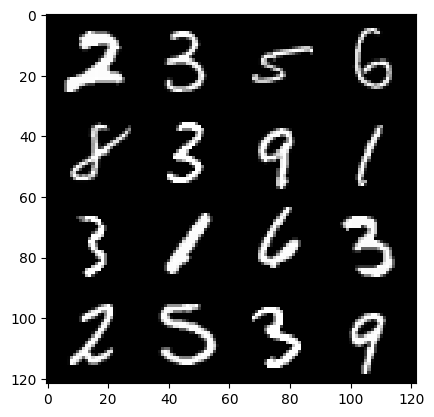

41 : step 19500 / Gen Loss: 0.01673388957977295 / disc loss: 8.580596496661505e-05


  0%|          | 0/469 [00:00<?, ?it/s]

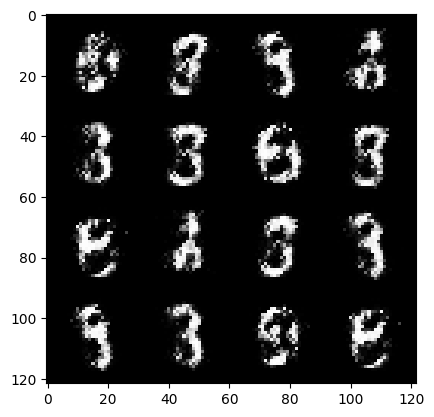

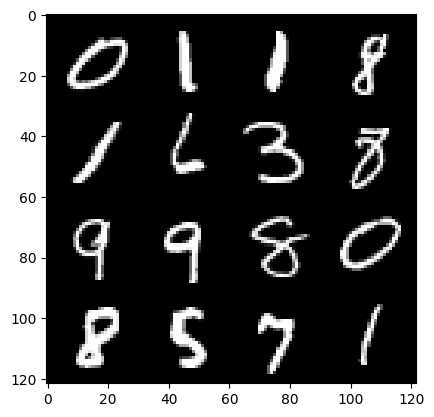

42 : step 19800 / Gen Loss: 0.017561610539754233 / disc loss: 8.280849705139796e-05


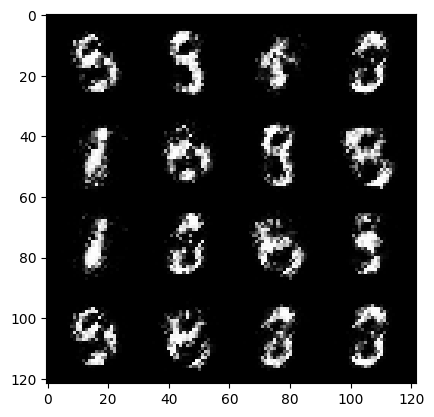

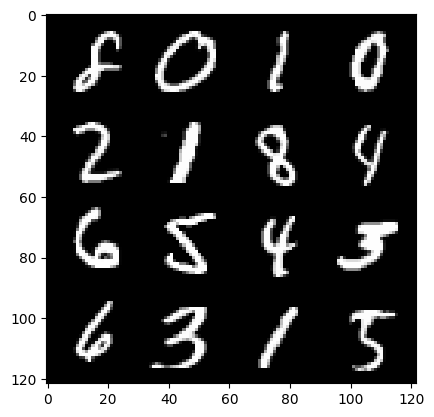

42 : step 20100 / Gen Loss: 0.018968502680460613 / disc loss: 9.173184012373289e-05


  0%|          | 0/469 [00:00<?, ?it/s]

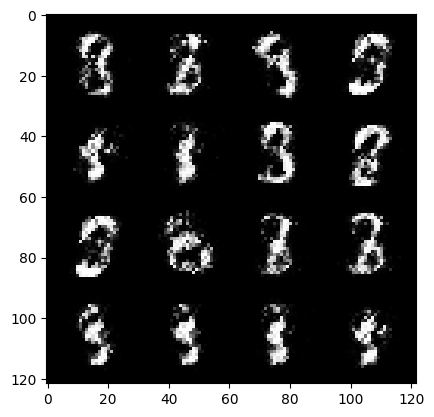

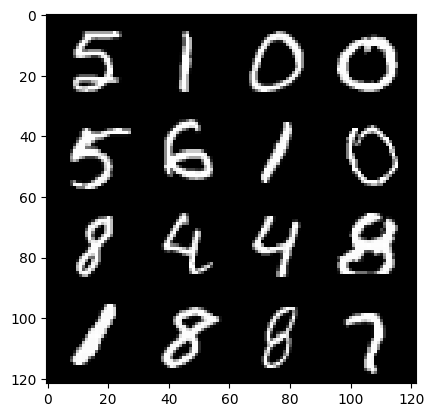

43 : step 20400 / Gen Loss: 0.019380839665730794 / disc loss: 4.207295986513297e-05


  0%|          | 0/469 [00:00<?, ?it/s]

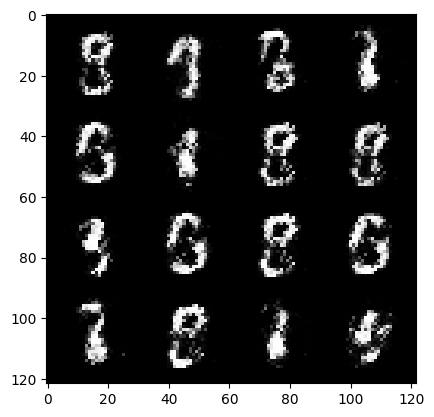

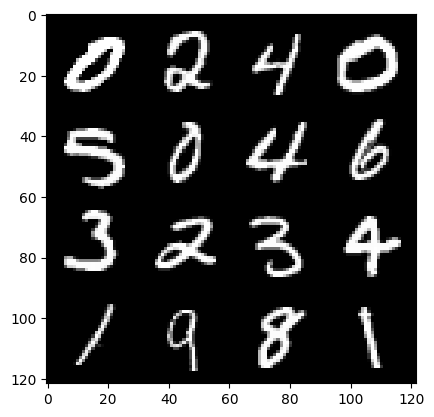

44 : step 20700 / Gen Loss: 0.019553165435791015 / disc loss: 5.0735265637437504e-05


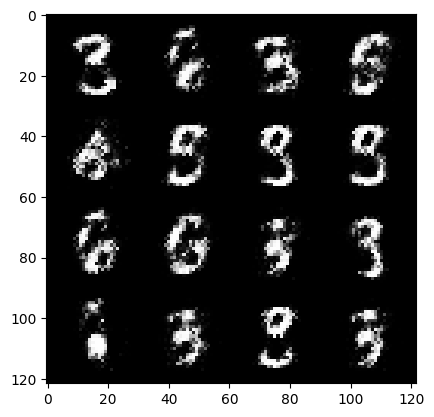

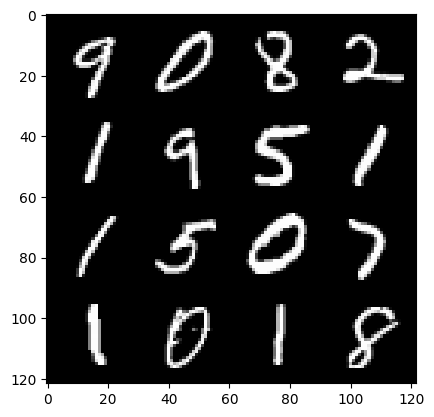

44 : step 21000 / Gen Loss: 0.01840802510579427 / disc loss: 8.094002803166707e-05


  0%|          | 0/469 [00:00<?, ?it/s]

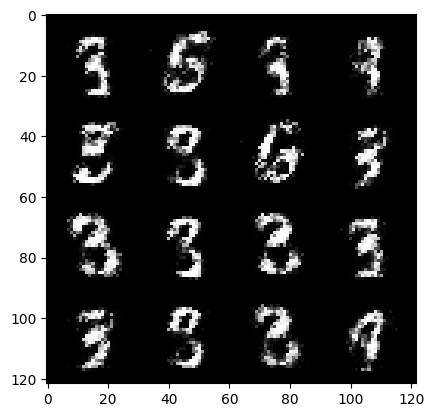

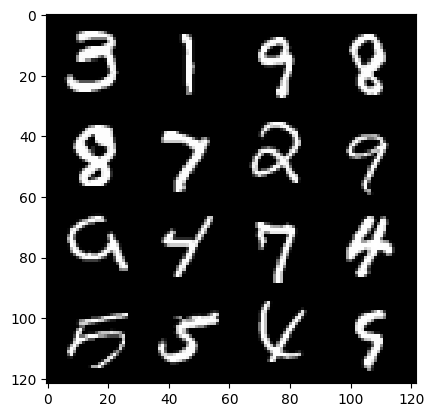

45 : step 21300 / Gen Loss: 0.020317071278889973 / disc loss: 0.00011430383970340094


  0%|          | 0/469 [00:00<?, ?it/s]

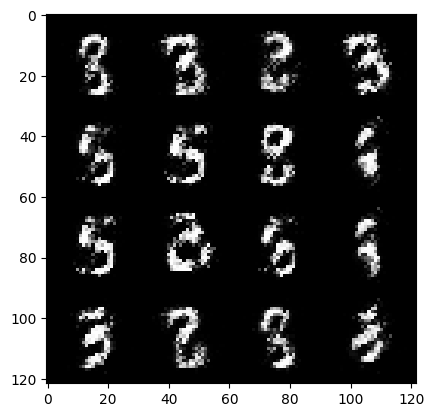

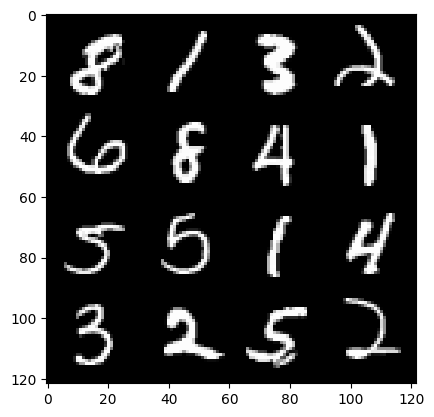

46 : step 21600 / Gen Loss: 0.019996538162231445 / disc loss: 6.993456433216731e-05


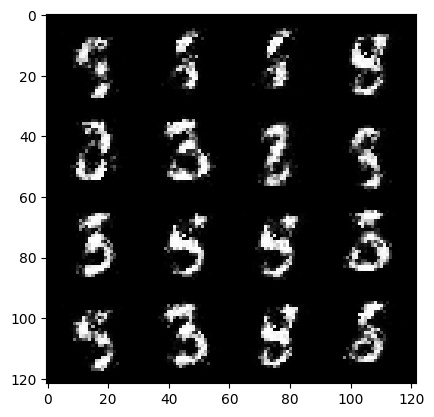

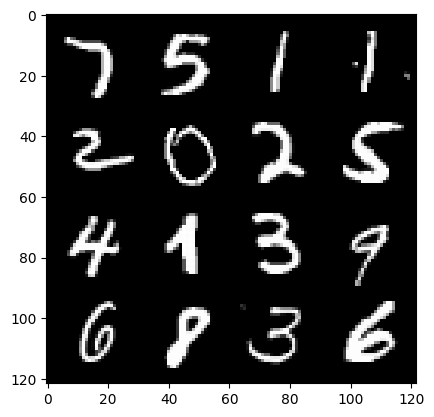

46 : step 21900 / Gen Loss: 0.016553961435953776 / disc loss: 0.00021455876529216766


  0%|          | 0/469 [00:00<?, ?it/s]

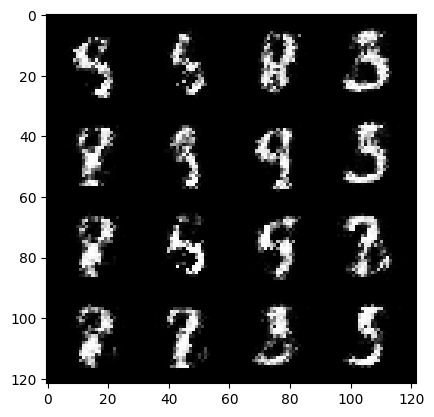

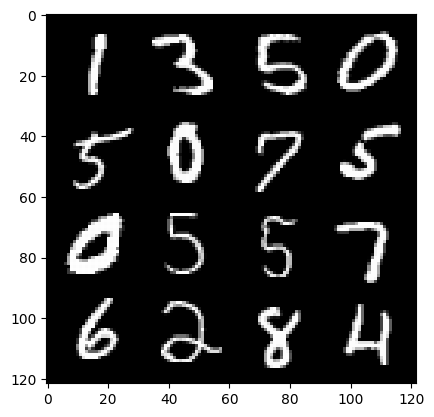

47 : step 22200 / Gen Loss: 0.018868279457092286 / disc loss: 6.216565767923991e-05


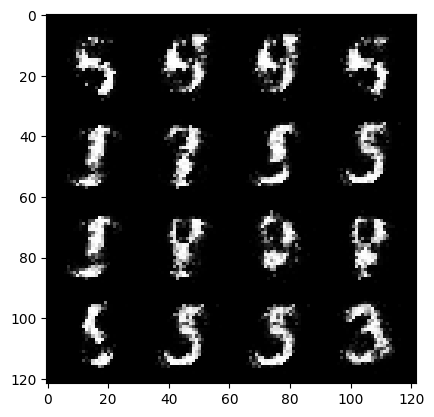

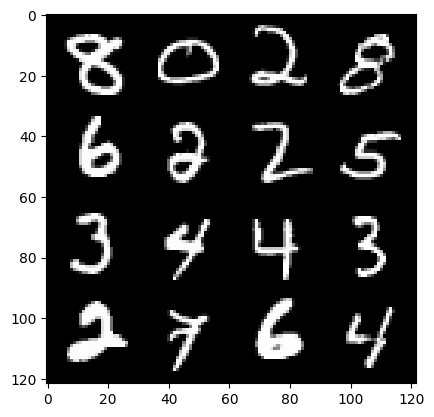

47 : step 22500 / Gen Loss: 0.020516719818115235 / disc loss: 0.0001067559669415156


  0%|          | 0/469 [00:00<?, ?it/s]

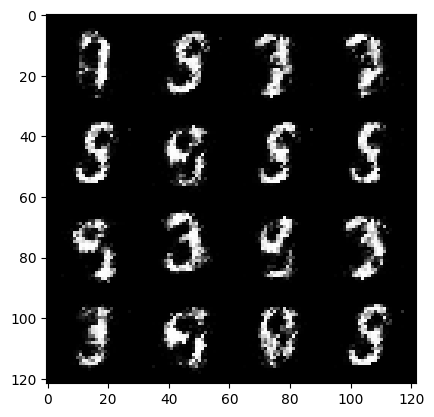

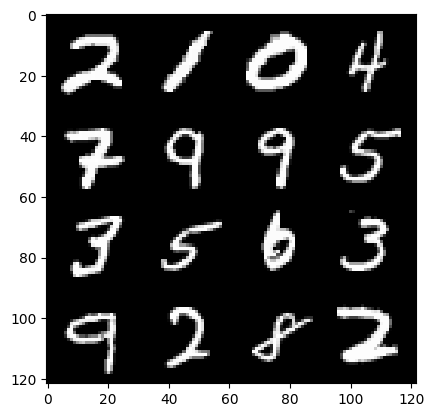

48 : step 22800 / Gen Loss: 0.01885353406270345 / disc loss: 0.00014963117738564809


  0%|          | 0/469 [00:00<?, ?it/s]

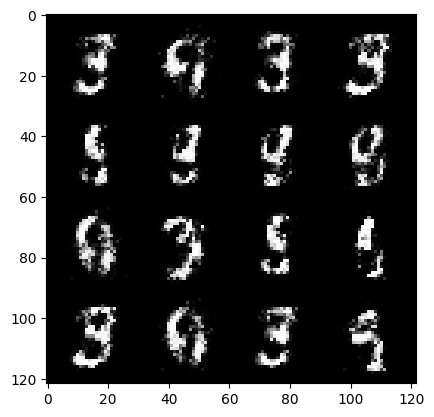

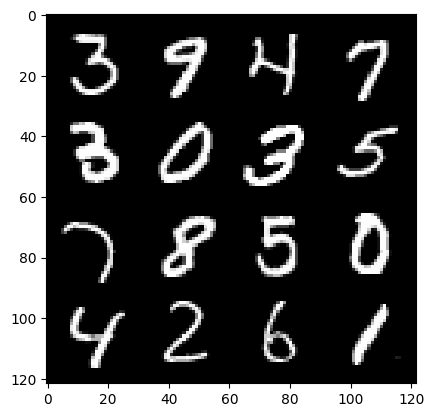

49 : step 23100 / Gen Loss: 0.01998485247294108 / disc loss: 0.00012867188702027002


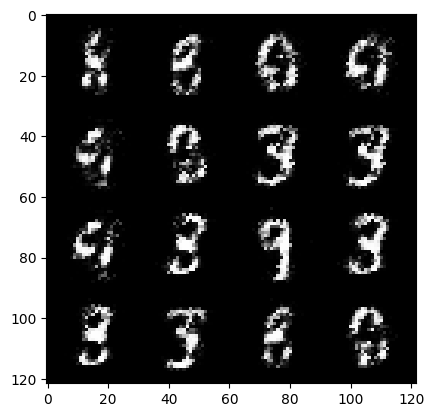

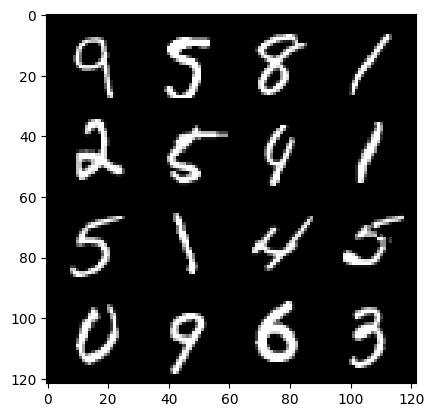

49 : step 23400 / Gen Loss: 0.017329368591308594 / disc loss: 9.227643410364787e-05


  0%|          | 0/469 [00:00<?, ?it/s]

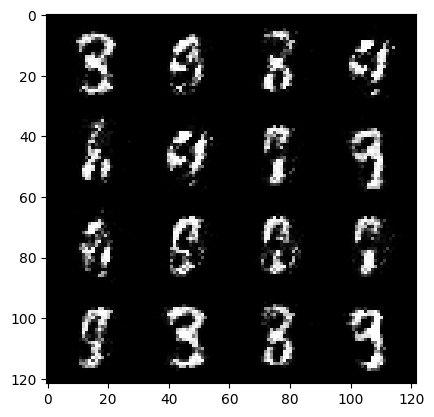

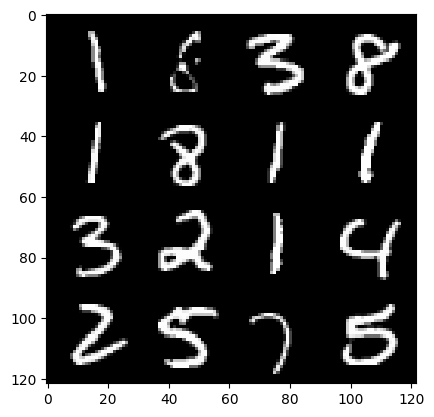

50 : step 23700 / Gen Loss: 0.017879570325215657 / disc loss: 9.721641118327776e-05


  0%|          | 0/469 [00:00<?, ?it/s]

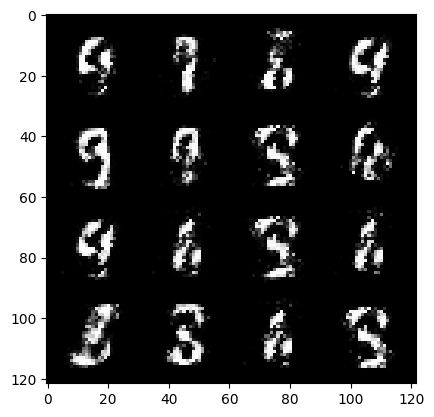

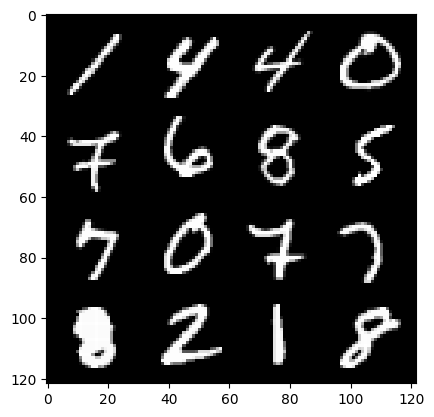

51 : step 24000 / Gen Loss: 0.0136529541015625 / disc loss: 9.074882914622625e-05


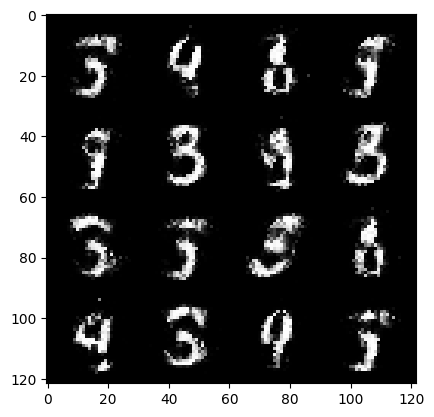

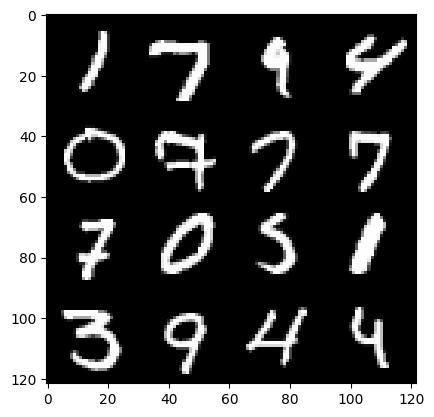

51 : step 24300 / Gen Loss: 0.01849255561828613 / disc loss: 0.0001260307803750038


  0%|          | 0/469 [00:00<?, ?it/s]

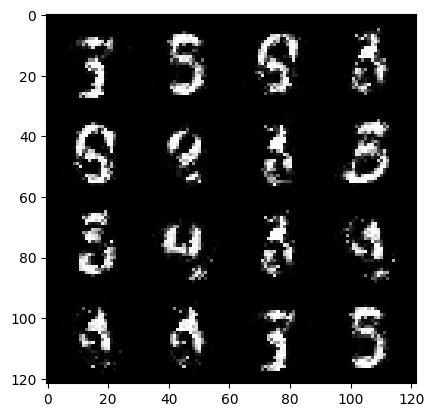

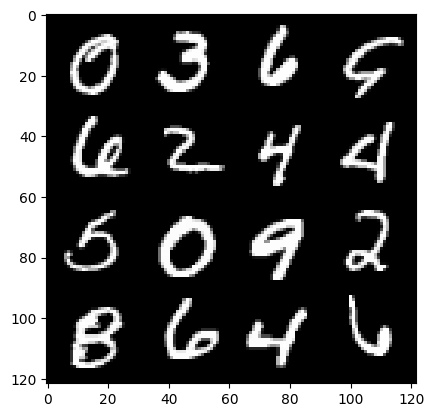

52 : step 24600 / Gen Loss: 0.019987742106119793 / disc loss: 6.55003140370051e-05


  0%|          | 0/469 [00:00<?, ?it/s]

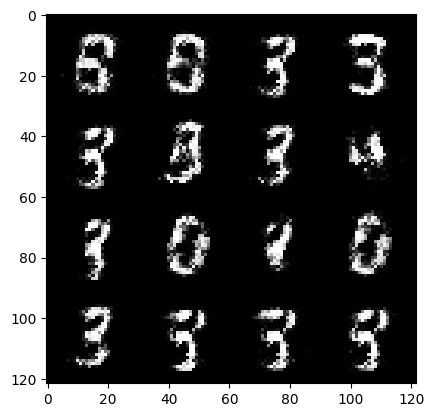

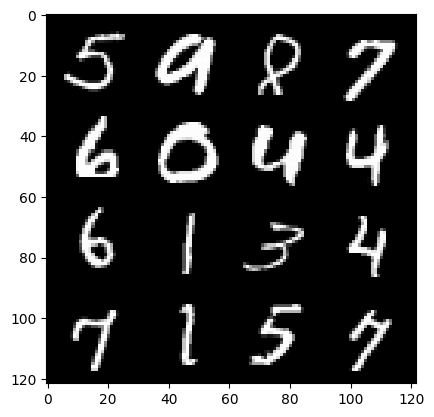

53 : step 24900 / Gen Loss: 0.020017944971720377 / disc loss: 0.00013731965174277623


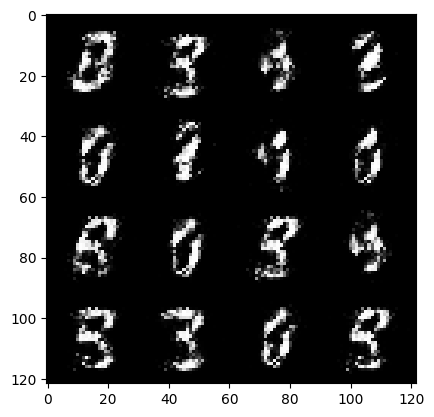

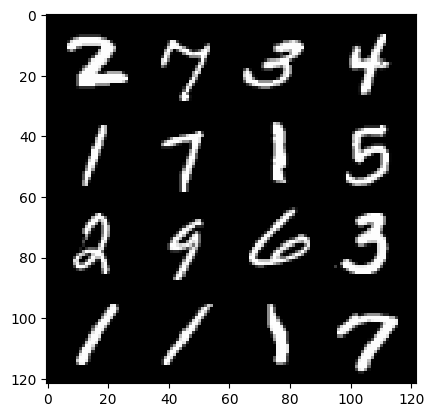

53 : step 25200 / Gen Loss: 0.0193017307917277 / disc loss: 0.0001355888694524765


  0%|          | 0/469 [00:00<?, ?it/s]

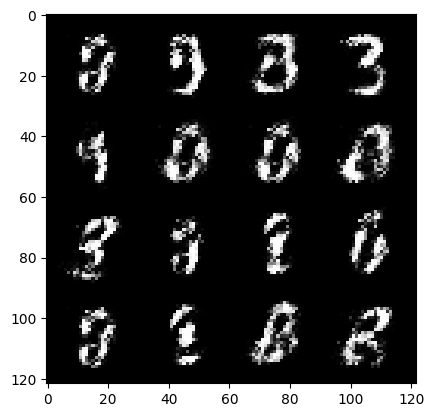

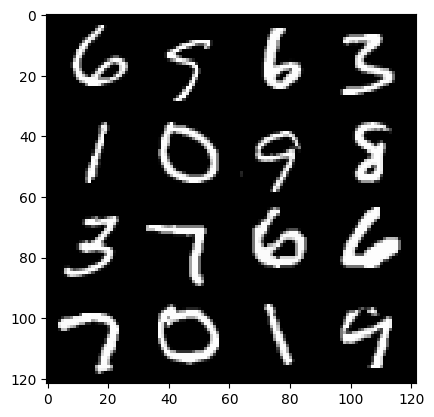

54 : step 25500 / Gen Loss: 0.022096632321675618 / disc loss: 0.00014859760800997417


  0%|          | 0/469 [00:00<?, ?it/s]

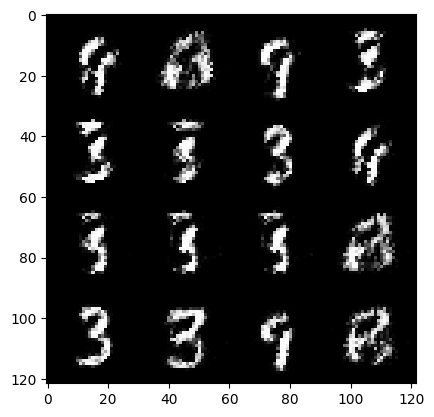

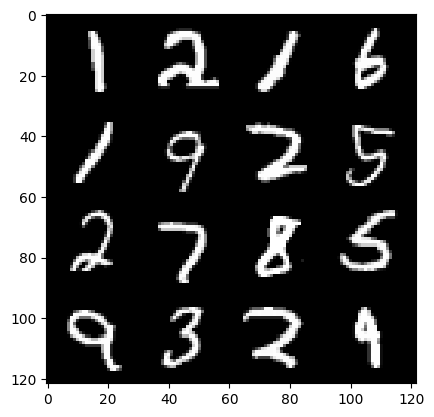

55 : step 25800 / Gen Loss: 0.020882542928059897 / disc loss: 0.00012100978444019953


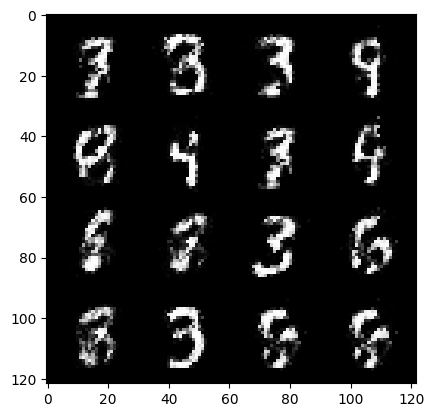

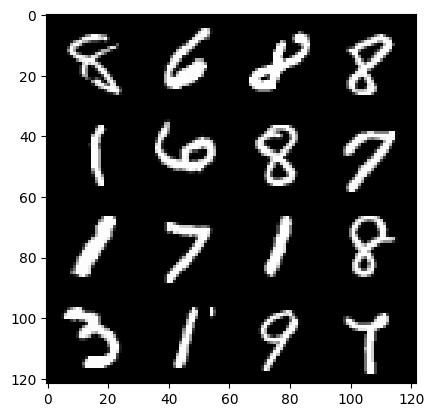

55 : step 26100 / Gen Loss: 0.012373779614766439 / disc loss: 0.00023337180415789288


  0%|          | 0/469 [00:00<?, ?it/s]

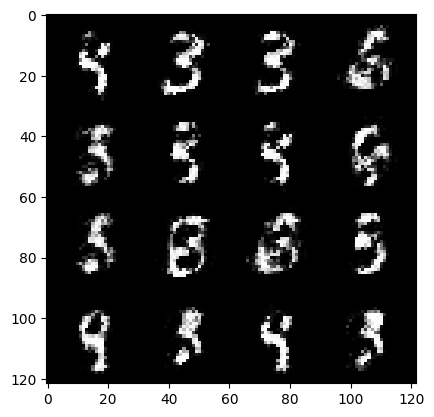

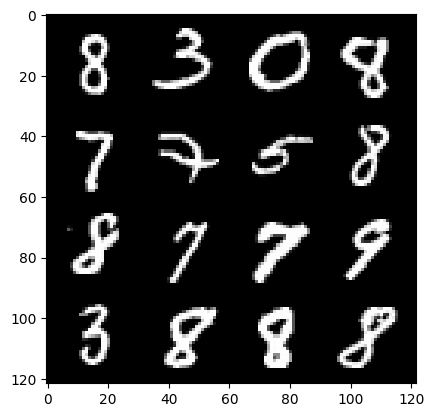

56 : step 26400 / Gen Loss: 0.018302432696024575 / disc loss: 0.00013993223508199055


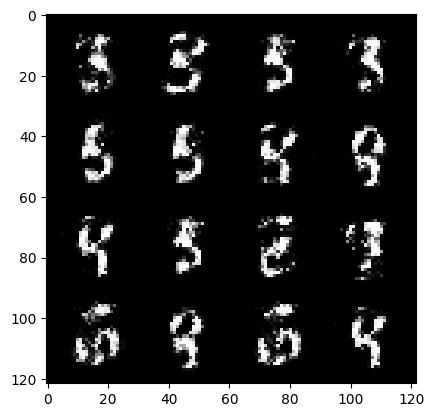

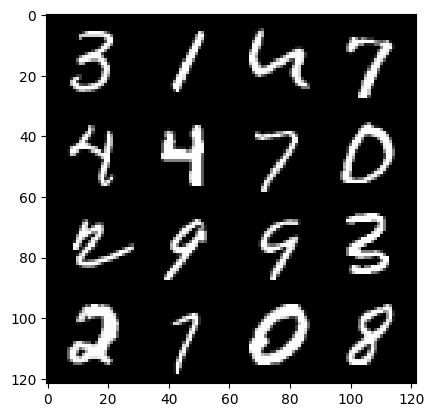

56 : step 26700 / Gen Loss: 0.019675774574279783 / disc loss: 0.00026217547555764515


  0%|          | 0/469 [00:00<?, ?it/s]

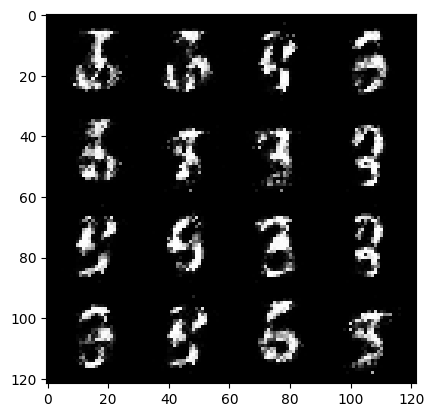

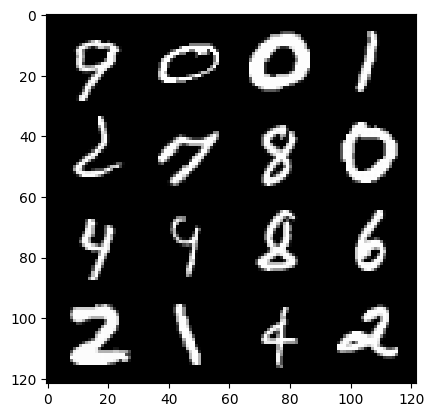

57 : step 27000 / Gen Loss: 0.02019244194030762 / disc loss: 0.00019600141793489457


  0%|          | 0/469 [00:00<?, ?it/s]

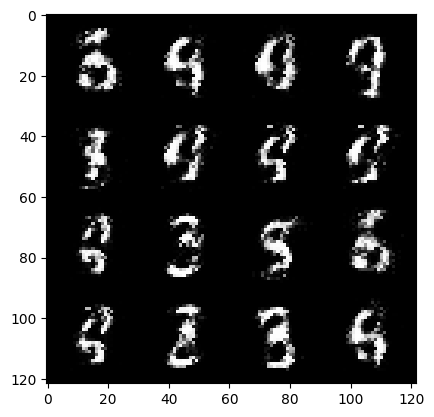

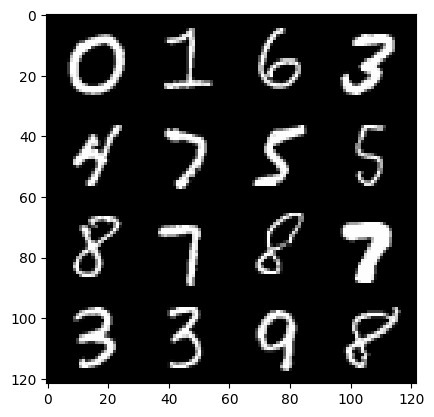

58 : step 27300 / Gen Loss: 0.014672958056131998 / disc loss: 0.0002708128343025843


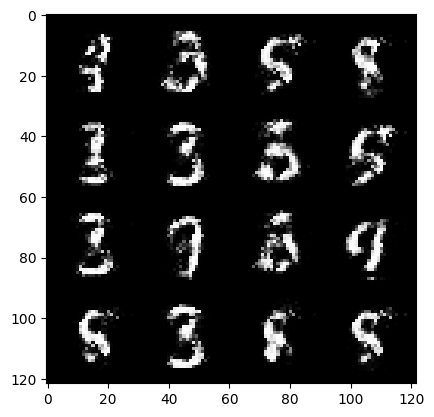

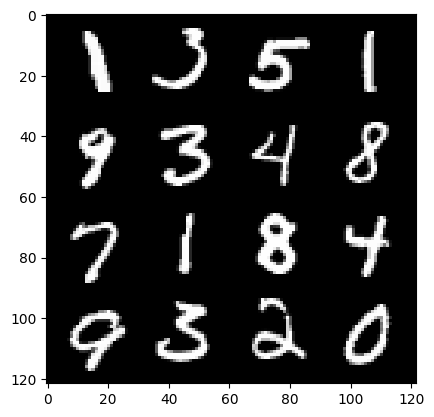

58 : step 27600 / Gen Loss: 0.01746339480082194 / disc loss: 0.0002705192565917969


  0%|          | 0/469 [00:00<?, ?it/s]

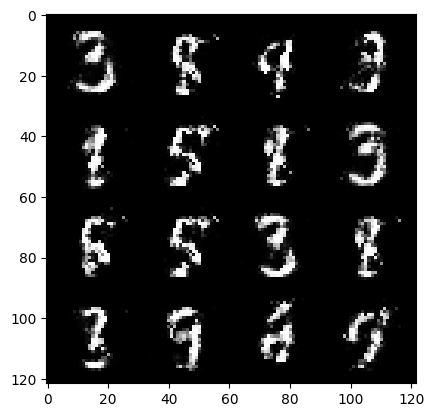

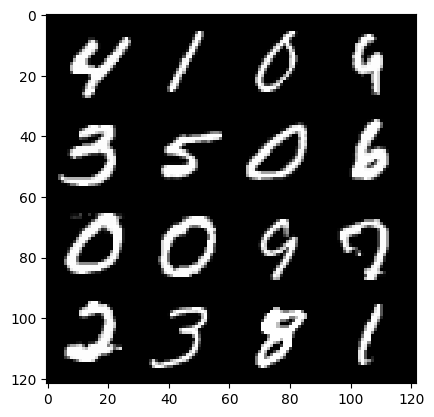

59 : step 27900 / Gen Loss: 0.015717660586039225 / disc loss: 0.00010783560574054719


  0%|          | 0/469 [00:00<?, ?it/s]

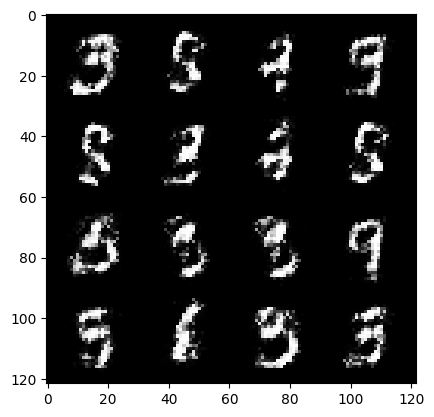

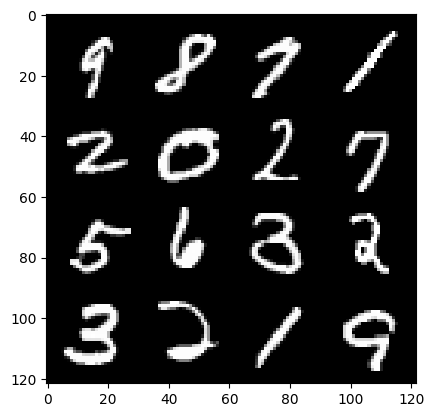

60 : step 28200 / Gen Loss: 0.017435487111409506 / disc loss: 0.0001477638011177381


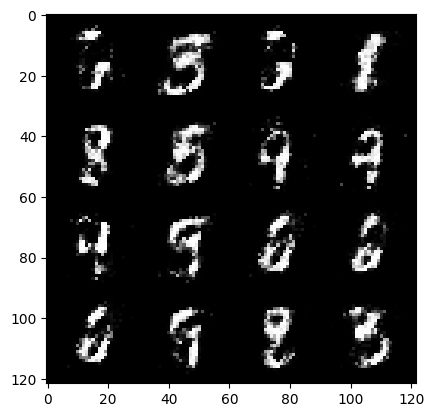

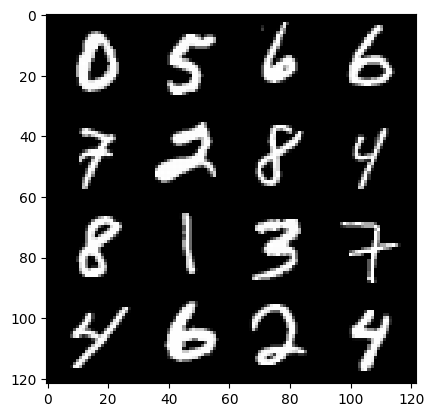

60 : step 28500 / Gen Loss: 0.02110344886779785 / disc loss: 0.00011028407762447993


  0%|          | 0/469 [00:00<?, ?it/s]

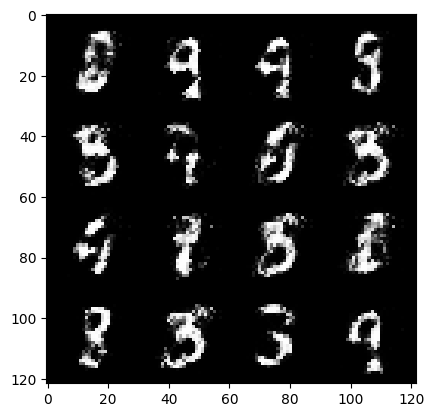

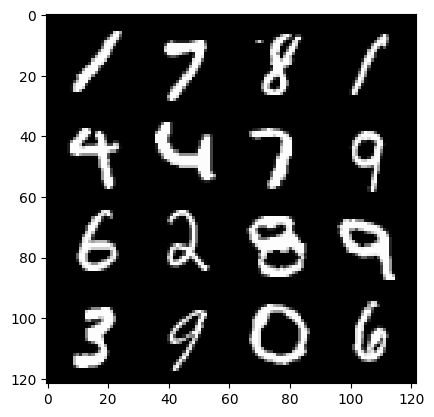

61 : step 28800 / Gen Loss: 0.01713476498921712 / disc loss: 0.00020135606328646342


  0%|          | 0/469 [00:00<?, ?it/s]

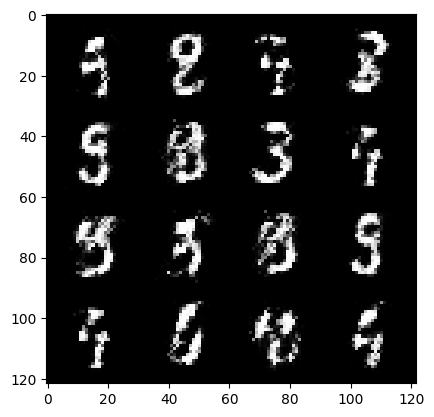

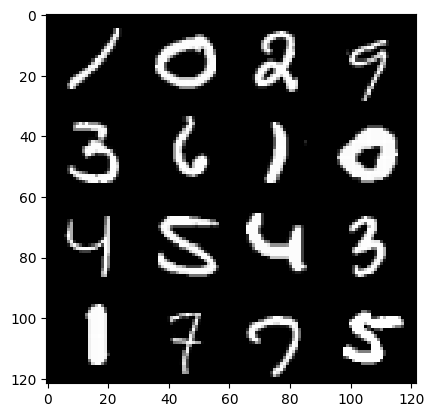

62 : step 29100 / Gen Loss: 0.018561372756958006 / disc loss: 0.00014739776651064555


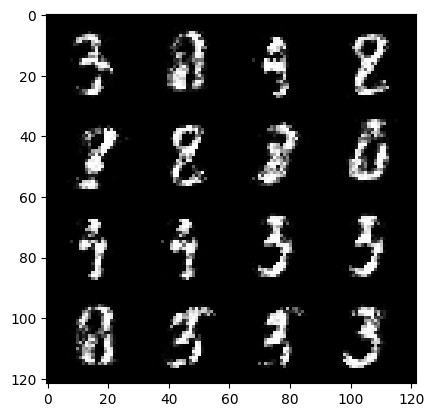

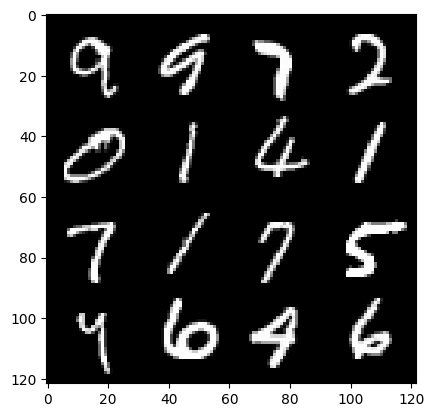

62 : step 29400 / Gen Loss: 0.016566066741943358 / disc loss: 0.00031975155075391134


  0%|          | 0/469 [00:00<?, ?it/s]

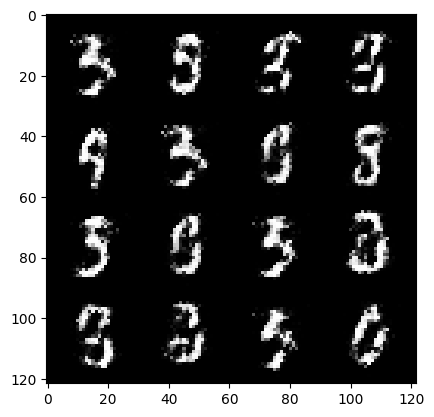

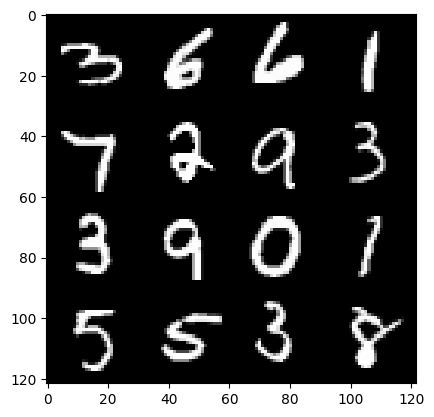

63 : step 29700 / Gen Loss: 0.01692149003346761 / disc loss: 0.000118137722214063


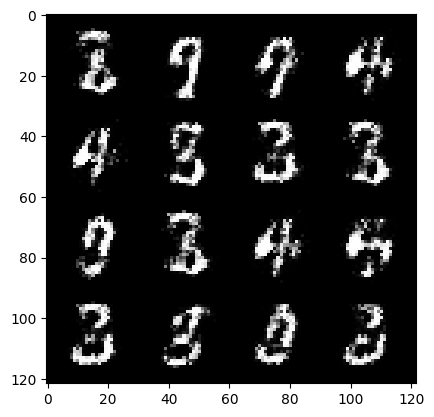

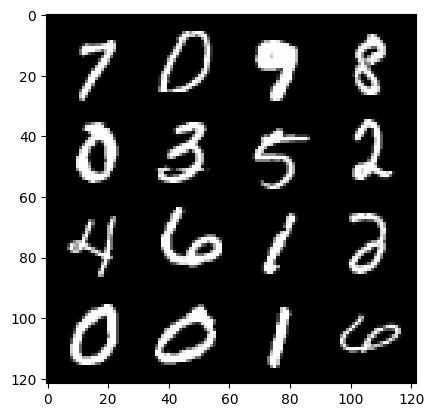

63 : step 30000 / Gen Loss: 0.017351579666137696 / disc loss: 0.0005268122255802154


  0%|          | 0/469 [00:00<?, ?it/s]

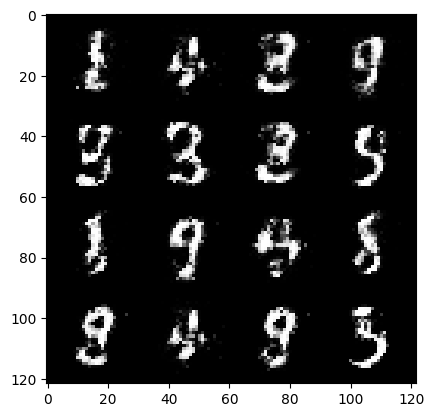

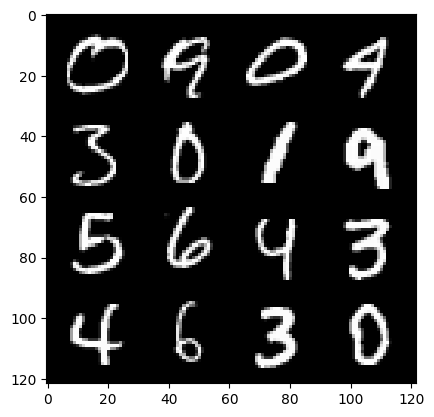

64 : step 30300 / Gen Loss: 0.015576763153076172 / disc loss: 0.00035527244210243226


  0%|          | 0/469 [00:00<?, ?it/s]

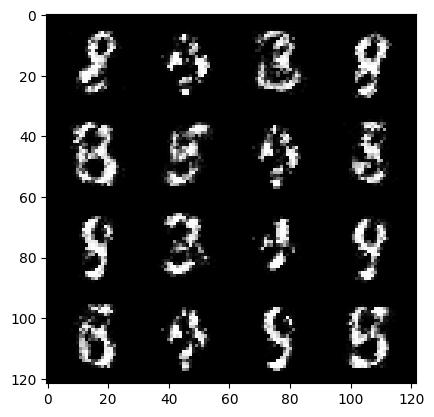

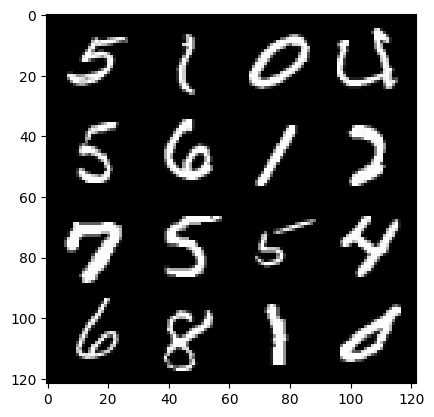

65 : step 30600 / Gen Loss: 0.01623213291168213 / disc loss: 0.00018459193408489226


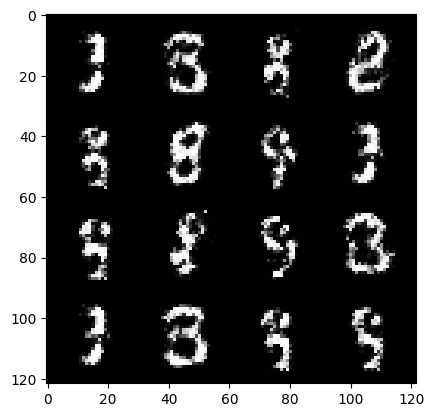

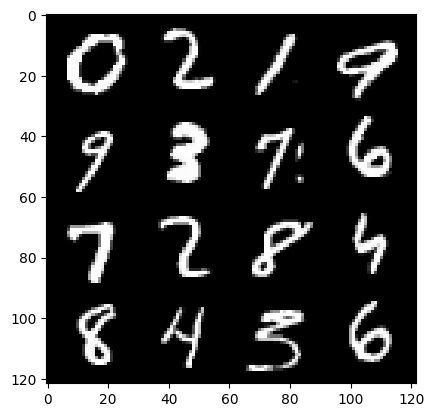

65 : step 30900 / Gen Loss: 0.013754603068033854 / disc loss: 0.00020916660626729328


  0%|          | 0/469 [00:00<?, ?it/s]

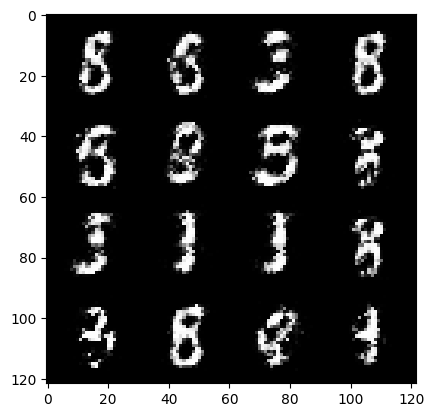

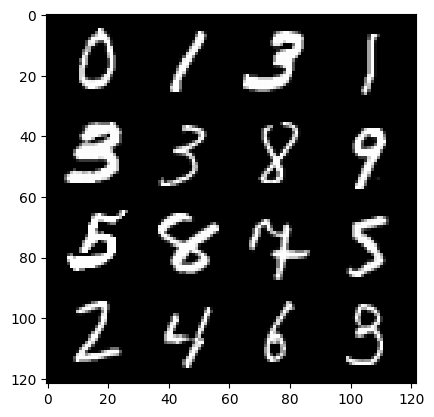

66 : step 31200 / Gen Loss: 0.012791714668273925 / disc loss: 0.00028052868942419687


In [ ]:
### 60000 / 128 = ~ 469 steps in each epochs
### Each steps is going to process 128 images = ie Size of batch, last one will process what is remaning with that batch

for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    ### Discriminator
    disc_optim.zero_grad()
    cur_bs = len(real) ### This will be equal to 128 X 1 X 28 X 28
    real =real.view (cur_bs,-1) ### -1 here refers that only two parameter from above will be used, first 128 and second 784 ie. 128 x 784(28x28)
    real =real.to(device)

    disc_loss = calc_disc_loss(loss_func,gen,disc,cur_bs, real,z_dim)

    disc_loss.backward(retain_graph = True)
    disc_optim.step()

    ### Generator
    gen_optim.zero_grad()
    gen_loss = calc_gen_loss(loss_func,gen,disc,cur_bs,z_dim)
    gen_loss.backward(retain_graph = True)
    gen_optim.step()

    ### Visulazation & Steps
    mean_disc_loss =0
    mean_gen_loss = 0
    mean_disc_loss+= disc_loss.item()/info_step # here item will transform tensor in numbers
    mean_gen_loss += gen_loss.item()/info_step

    if cur_step % info_step == 0 and cur_step > 0:
      fake_noise = gen_noise(cur_bs, z_dim)
      fake = gen(fake_noise)
      show (fake)
      show(real)
      print(f"{ epoch} : step {cur_step} / Gen Loss: {mean_gen_loss} / disc loss: {mean_disc_loss}")
      mean_gen_loss, mean_disc_loss = 0,0
    cur_step +=1

